# Capstone project - Analysis on Animal rescue incidents attended by London Fire Brigade

<a name="intro"></a>The London Fire Brigade attends a range of non-fire incidents (known as 'special services'). These 'special services' include assistance to animals that may be trapped or in distress.

The dataset can be found on https://data.london.gov.uk/dataset/animal-rescue-incidents-attended-by-lfb

### Index  <a name="top"></a>

1. [Introduction and initial thoughts](#intro)

2. [Initial Data Analysis](#ida)

3. [Exploratory Data Analysis](#eda)

4. [Visualization and Plots](#viz)

5. [KNN](#knn)

6. [Time-Series (incomplete)](#time)

My analysis and projects tries to answer / prove the following hypotheses: 
1. Which pincode / locale has the most number of incidents?
2. Are wild animal incidents found in locales near parks?
3. Do we see a lot more incidents after major holidays?
4. Do we see a higher rate of incidents near the outskirts of London?
5. Are response times longer for locations close to the outskirts?
6. Are costs higher as well?
7. How did these stats change over the pandemic?

#### What do you know about the dataset so far?

- there are 31 columns and over 10.3K rows
- Some columns are blank or even redacted
- The records have timestamps - which can be cleaned
- there are also latitude and longitude columns - need to check if it's possible to map these?

#### Why did I choose this dataset?

Personal story - my cat had climbed up a tall tree, and I had to indeed call the fire services to get him down.

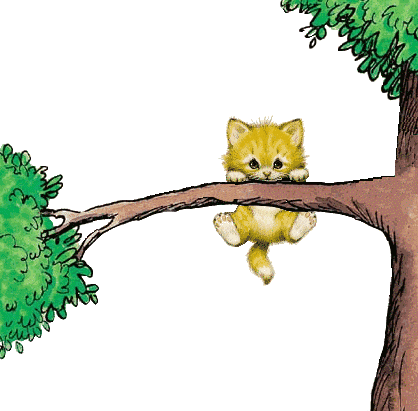

### Initial Data Analysis  <a name="ida"></a> [back to Index](#top)

As there's a lot of data to go through, my first few tasks are:
- Understand the data available in each column
- Identify any missing or inconsistent data points

Jump to IDA summary below [link](#ida_summary)

###### Import statements

In [1]:
#Standard input libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

#Plotting/ visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'notebook'

#M/L libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

###### Helper functions

In [2]:
#Helper function to check common attributes for a column
def column_analyzer(name):
    uniq_count = name.nunique()
    uniq_list = name.unique()
    null_sum = name.isnull().sum()
    col_data = name.dtype
    print(f"The data type is {col_data}")
    print(f"The unique value count for is {uniq_count}")
    print(f"The unique values are ", uniq_list)
    print(f"The null count is {null_sum}")

#Helper function to group Animals
def categorize_animaltype(animal):
    if animal in ["Cat", "Dog", "Rabbit", "Budgie", "Unknown - Domestic Animal or Pet", "Hamster", "Ferret"]:
        return "Pets"
    elif animal in ["Horse", "Unknown - Heavy Livestock Animal", "Cow", "Sheep", "Goat", "Unknown - Animal rescue from water - Farm animal", "Lamb", "Bull", "Unknown - Animal rescue from below ground - Farm animal", "Tortoise"]:
        return "Farm_animals"
    elif animal in ["Bird", "Pigeon"]:
        return "Birds"
    elif animal in ["Fox", "Deer", "Unknown - Wild Animal", "Squirrel", "Snake", "Hedgehog", "Lizard", "Fish"]:
        return "Wild_animals"
    else:
        return "Others"
    
    
#Helper function to group Boroughs together
def subregion(borough):
    if borough in map(str.upper, ["Camden", "City of London", "Kensington and Chelsea", "Islington", "Lambeth", "Southwark", "Westminster"]):
        return "Central"
    elif borough in map(str.upper, ["Barking and Dagenham", "Bexley", "Greenwich", "Hackney", "Havering", "Lewisham", "Newham", "Redbridge", "Tower Hamlets", "Waltham Forest"]):
        return "East"
    elif borough in map(str.upper, ["Barnet", "Enfield", "Haringey"]):
        return "North"
    elif borough in map(str.upper, ["Bromley", "Croydon", "Kingston upon Thames", "Merton", "Sutton", "Wandsworth"]):
        return "South"
    elif borough in map(str.upper, ["Brent", "Ealing", "Hammersmith and Fulham", "Harrow", "Richmond upon Thames", "Hillingdon", "Hounslow"]):
        return "West"
    else:
        return "Outside London"

###### Ignores for warnings and other misc. code

In [96]:
#import warnings
#from sklearn.exceptions import UndefinedMetricWarning
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning
#warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

##### Loading the data and statistics

In [4]:
lfb = pd.read_csv("lfb.csv")
lfb

,IncidentNumber,DateTimeOfCall,CalYear,FinYear,TypeOfIncident,PumpCount,PumpHoursTotal,HourlyNotionalCost(£),IncidentNotionalCost(£),FinalDescription,AnimalGroupParent,OriginofCall,PropertyType,PropertyCategory,SpecialServiceTypeCategory,SpecialServiceType,WardCode,Ward,BoroughCode,Borough,StnGroundName,UPRN,Street,USRN,PostcodeDistrict,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude
0,139091,01/01/2009 03:01,2009,2008/09,Special Service,1.0,2.0,255,510.0,Redacted,Dog,Person (land line),House - single occupancy,Dwelling,Other animal assistance,Animal assistance involving livestock - Other ...,E05011467,Crystal Palace & Upper Norwood,E09000008,Croydon,Norbury,NaN,Waddington Way,20500146.0,SE19,NaN,NaN,532350,170050,NaN,NaN
1,275091,01/01/2009 08:51,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Fox,Person (land line),Railings,Outdoor Structure,Other animal assistance,Animal assistance involving livestock - Other ...,E05000169,Woodside,E09000008,Croydon,Woodside,NaN,Grasmere Road,NaN,SE25,534785.0,167546.0,534750,167550,51.390954,-0.064167
2,2075091,04/01/2009 10:07,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Dog,Person (mobile),Pipe or drain,Outdoor Structure,Animal rescue from below ground,Animal rescue from below ground - Domestic pet,E05013756,Carshalton Central,E09000029,Sutton,Wallington,NaN,Mill Lane,NaN,SM5,528041.0,164923.0,528050,164950,51.368941,-0.161985
3,2872091,05/01/2009 12:27,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Horse,Person (mobile),"Intensive Farming Sheds (chickens, pigs etc)",Non Residential,Animal rescue from water,Animal rescue from water - Farm animal,E05013568,Harefield Village,E09000017,Hillingdon,Ruislip,1.000210e+11,Park Lane,21401484.0,UB9,504689.0,190685.0,504650,190650,51.605283,-0.489684
4,3553091,06/01/2009 15:23,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Rabbit,Person (mobile),House - single occupancy,Dwelling,Other animal assistance,Animal assistance involving livestock - Other ...,E05013971,Gooshays,E09000016,Havering,Harold Hill,NaN,Swindon Lane,21300122.0,RM3,NaN,NaN,554650,192350,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10327,205155-30122023,30/12/2023 13:23,2023,2023/24,Special Service,1.0,1.0,388,388.0,CAT ON ROOF TRAPPED - CALLER STATES BY GUTTERI...,Cat,Person (mobile),House - single occupancy,Dwelling,Animal rescue from height,Animal rescue from height - Domestic pet,E05013510,STONEBRIDGE,E09000005,BRENT,Park Royal,NaN,WYBORNE WAY,20200857.0,NW10,NaN,NaN,520150,184250,NaN,NaN
10328,205351-30122023,30/12/2023 19:44,2023,2023/24,Special Service,1.0,1.0,388,388.0,Redacted,Cat,Person (mobile),Purpose Built Flats/Maisonettes - Up to 3 stor...,Dwelling,Animal rescue from height,Animal rescue from height - Domestic pet,E05011116,SOUTH BERMONDSEY,E09000028,SOUTHWARK,Old Kent Road,NaN,HAZEL WAY,22501227.0,SE1,NaN,NaN,533750,178850,NaN,NaN
10329,205694-31122023,31/12/2023 12:08,2023,2023/24,Special Service,1.0,1.0,388,388.0,CAT TRAPPED BETWEEN TWO HOUSES OWNER IN ATTEN...,Cat,Person (mobile),House - single occupancy,Dwelling,Other animal assistance,Assist trapped domestic animal,E05013689,PONDERS END,E09000010,ENFIELD,Edmonton,NaN,CHURCH ROAD,20702181.0,EN3,NaN,NaN,535450,195350,NaN,NaN
10330,205809-31122023,31/12/2023 15:57,2023,2023/24,Special Service,1.0,1.0,388,388.0,Redacted,Fox,Person (mobile),Licensed House in Multiple Occupation - 3 or m...,Dwelling,Other animal assistance,Assist trapped wild animal,E05013501,HARLESDEN & KENSAL GREEN,E09000005,BRENT,Park Royal,NaN,MINET AVENUE,20201376.0,NW10,NaN,NaN,521050,183450,NaN,NaN


In [5]:
lfb.head(15)

,IncidentNumber,DateTimeOfCall,CalYear,FinYear,TypeOfIncident,PumpCount,PumpHoursTotal,HourlyNotionalCost(£),IncidentNotionalCost(£),FinalDescription,AnimalGroupParent,OriginofCall,PropertyType,PropertyCategory,SpecialServiceTypeCategory,SpecialServiceType,WardCode,Ward,BoroughCode,Borough,StnGroundName,UPRN,Street,USRN,PostcodeDistrict,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude
0,139091,01/01/2009 03:01,2009,2008/09,Special Service,1.0,2.0,255,510.0,Redacted,Dog,Person (land line),House - single occupancy,Dwelling,Other animal assistance,Animal assistance involving livestock - Other ...,E05011467,Crystal Palace & Upper Norwood,E09000008,Croydon,Norbury,NaN,Waddington Way,20500146.0,SE19,NaN,NaN,532350,170050,NaN,NaN
1,275091,01/01/2009 08:51,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Fox,Person (land line),Railings,Outdoor Structure,Other animal assistance,Animal assistance involving livestock - Other ...,E05000169,Woodside,E09000008,Croydon,Woodside,NaN,Grasmere Road,NaN,SE25,534785.0,167546.0,534750,167550,51.390954,-0.064167
2,2075091,04/01/2009 10:07,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Dog,Person (mobile),Pipe or drain,Outdoor Structure,Animal rescue from below ground,Animal rescue from below ground - Domestic pet,E05013756,Carshalton Central,E09000029,Sutton,Wallington,NaN,Mill Lane,NaN,SM5,528041.0,164923.0,528050,164950,51.368941,-0.161985
3,2872091,05/01/2009 12:27,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Horse,Person (mobile),"Intensive Farming Sheds (chickens, pigs etc)",Non Residential,Animal rescue from water,Animal rescue from water - Farm animal,E05013568,Harefield Village,E09000017,Hillingdon,Ruislip,1.000210e+11,Park Lane,21401484.0,UB9,504689.0,190685.0,504650,190650,51.605283,-0.489684
4,3553091,06/01/2009 15:23,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Rabbit,Person (mobile),House - single occupancy,Dwelling,Other animal assistance,Animal assistance involving livestock - Other ...,E05013971,Gooshays,E09000016,Havering,Harold Hill,NaN,Swindon Lane,21300122.0,RM3,NaN,NaN,554650,192350,NaN,NaN
5,3742091,06/01/2009 19:30,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Unknown - Heavy Livestock Animal,Person (land line),House - single occupancy,Dwelling,Other animal assistance,Animal assistance involving livestock - Other ...,E05014054,Alibon,E09000002,Barking and Dagenham,Dagenham,NaN,Rogers Road,19900321.0,RM10,NaN,NaN,549350,184950,NaN,NaN
6,4011091,07/01/2009 06:29,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Dog,Person (land line),Park,Outdoor,Other animal assistance,Animal assistance involving livestock - Other ...,E05013883,Cathall,E09000031,Waltham Forest,Leytonstone,NaN,Holloway Road,NaN,E11,539013.0,186162.0,539050,186150,51.557221,0.003880
7,4211091,07/01/2009 11:55,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Dog,Person (mobile),Lake/pond/reservoir,Outdoor,Animal rescue from water,Animal rescue from water - Domestic pet,E05000515,Wanstead,E09000026,Redbridge,Leytonstone,NaN,Aldersbrook Road,NaN,E12,541327.0,186654.0,541350,186650,51.561067,0.037434
8,4306091,07/01/2009 13:48,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Squirrel,Person (land line),House - single occupancy,Dwelling,Animal rescue from height,Wild animal rescue from height,E05011470,New Addington North,E09000008,Croydon,Addington,NaN,Brockham Crescent,20501673.0,CR0,NaN,NaN,538750,163350,NaN,NaN
9,4715091,07/01/2009 21:24,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,Dog,Person (mobile),River/canal,Outdoor,Animal rescue from water,Animal rescue from water - Domestic pet,E05009380,Lea Bridge,E09000012,Hackney,Stoke Newington,NaN,Southwold Road,NaN,E5,535425.0,186743.0,535450,186750,51.563314,-0.047621


In [6]:
lfb.shape

(10332, 31)

In [7]:
lfb.columns

Index(['IncidentNumber', 'DateTimeOfCall', 'CalYear', 'FinYear',
       'TypeOfIncident', 'PumpCount', 'PumpHoursTotal',
       'HourlyNotionalCost(£)', 'IncidentNotionalCost(£)', 'FinalDescription',
       'AnimalGroupParent', 'OriginofCall', 'PropertyType', 'PropertyCategory',
       'SpecialServiceTypeCategory', 'SpecialServiceType', 'WardCode', 'Ward',
       'BoroughCode', 'Borough', 'StnGroundName', 'UPRN', 'Street', 'USRN',
       'PostcodeDistrict', 'Easting_m', 'Northing_m', 'Easting_rounded',
       'Northing_rounded', 'Latitude', 'Longitude'],
      dtype='object')

In [8]:
lfb.dtypes

IncidentNumber                 object
DateTimeOfCall                 object
CalYear                         int64
FinYear                        object
TypeOfIncident                 object
PumpCount                     float64
PumpHoursTotal                float64
HourlyNotionalCost(£)           int64
IncidentNotionalCost(£)       float64
FinalDescription               object
AnimalGroupParent              object
OriginofCall                   object
PropertyType                   object
PropertyCategory               object
SpecialServiceTypeCategory     object
SpecialServiceType             object
WardCode                       object
Ward                           object
BoroughCode                    object
Borough                        object
StnGroundName                  object
UPRN                          float64
Street                         object
USRN                          float64
PostcodeDistrict               object
Easting_m                     float64
Northing_m  

###### Check for missing values in records

In [9]:
lfb.isnull().values.any()

True

In [10]:
lfb.isnull().sum()

IncidentNumber                   0
DateTimeOfCall                   0
CalYear                          0
FinYear                          0
TypeOfIncident                   0
PumpCount                       71
PumpHoursTotal                  72
HourlyNotionalCost(£)            0
IncidentNotionalCost(£)         72
FinalDescription                 5
AnimalGroupParent                0
OriginofCall                     0
PropertyType                     0
PropertyCategory                 0
SpecialServiceTypeCategory       0
SpecialServiceType               0
WardCode                        11
Ward                            11
BoroughCode                     13
Borough                         13
StnGroundName                    0
UPRN                          6494
Street                           0
USRN                          1156
PostcodeDistrict                 0
Easting_m                     5475
Northing_m                    5475
Easting_rounded                  0
Northing_rounded    

In [11]:
lfb.describe(include="all")

,IncidentNumber,DateTimeOfCall,CalYear,FinYear,TypeOfIncident,PumpCount,PumpHoursTotal,HourlyNotionalCost(£),IncidentNotionalCost(£),FinalDescription,AnimalGroupParent,OriginofCall,PropertyType,PropertyCategory,SpecialServiceTypeCategory,SpecialServiceType,WardCode,Ward,BoroughCode,Borough,StnGroundName,UPRN,Street,USRN,PostcodeDistrict,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude
count,10332,10332,10332.000000,10332,10332,10261.000000,10260.000000,10332.000000,10260.000000,10327,10332,10332,10332,10332,10332,10332,10321,10321,10319,10319,10332,3.838000e+03,10332,9.176000e+03,10332,4857.000000,4857.000000,10332.000000,10332.000000,4857.000000,4857.000000
unique,10332,10316,NaN,16,1,NaN,NaN,NaN,NaN,6267,28,8,190,7,4,24,760,1327,37,70,109,NaN,7519,NaN,279,NaN,NaN,NaN,NaN,NaN,NaN
top,139091,11/12/2016 21:08,NaN,2022/23,Special Service,NaN,NaN,NaN,NaN,Redacted,Cat,Person (mobile),House - single occupancy,Dwelling,Other animal assistance,Animal rescue from height - Domestic pet,E05013971,Gooshays,E09000010,ENFIELD,Enfield,NaN,HIGH STREET,NaN,CR0,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,2,NaN,1036,10332,NaN,NaN,NaN,NaN,1536,5172,6537,2702,5475,4912,2525,53,42,483,319,210,NaN,49,NaN,187,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2016.865079,NaN,NaN,1.017250,1.172710,319.623790,374.150097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.029136e+10,NaN,2.096481e+07,NaN,531081.319127,180825.247066,531126.829268,180856.349206,51.479247,-0.112386
std,NaN,NaN,4.546514,NaN,NaN,0.139599,0.604751,42.596047,194.899725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.942572e+10,NaN,2.529948e+06,NaN,11116.535859,8724.656370,10443.412761,8295.124907,1.282321,0.160406
min,NaN,NaN,2009.000000,NaN,NaN,1.000000,0.000000,255.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.005910e+06,NaN,4.802548e+06,NaN,500025.000000,137468.000000,500050.000000,137450.000000,0.000000,-0.559730
25%,NaN,NaN,2013.000000,NaN,NaN,1.000000,1.000000,290.000000,290.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.021315e+08,NaN,2.050228e+07,NaN,523990.000000,174952.000000,524750.000000,175350.000000,51.457462,-0.215739
50%,NaN,NaN,2017.000000,NaN,NaN,1.000000,1.000000,328.000000,333.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.003342e+10,NaN,2.130076e+07,NaN,531786.000000,181218.000000,531550.000000,181450.000000,51.515334,-0.103517
75%,NaN,NaN,2021.000000,NaN,NaN,1.000000,1.000000,352.000000,364.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000220e+11,NaN,2.220106e+07,NaN,537894.000000,187190.000000,537550.000000,186850.000000,51.568128,-0.013742


###### Checking data within each column

In [12]:
#running a helper function to check all columns
for col in lfb.columns:
    print("Analysis for column", col)
    column_analyzer(lfb[col])

Analysis for column IncidentNumber
The data type is object
The unique value count for is 10332
The unique values are  ['139091' '275091' '2075091' ... '205694-31122023' '205809-31122023'
 '205998-31122023']
The null count is 0
Analysis for column DateTimeOfCall
The data type is object
The unique value count for is 10316
The unique values are  ['01/01/2009 03:01' '01/01/2009 08:51' '04/01/2009 10:07' ...
 '31/12/2023 12:08' '31/12/2023 15:57' '31/12/2023 22:15']
The null count is 0
Analysis for column CalYear
The data type is int64
The unique value count for is 15
The unique values are  [2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023]
The null count is 0
Analysis for column FinYear
The data type is object
The unique value count for is 16
The unique values are  ['2008/09' '2009/10' '2010/11' '2011/12' '2012/13' '2013/14' '2014/15'
 '2015/16' '2016/17' '2017/18' '2018/19' '2019/20' '2020/21' '2021/22'
 '2022/23' '2023/24']
The null count is 0
Analysis for colu

###### Initial Data Analysis Summary <a name="ida_summary">

- 10332 rows and 31 records
- only 13 columns with int/float type data, with the rest as object/strings
- there are 3 columns with time characteristics (DateTimeOfCall, CalYear, and FinYear) - but they aren't of type datetime
- Some of the geo-location columns (Latitude, Longitude, Easting, Northing etc.) have a lot of null records

To round out the IDA, I listed out all the columns below and grouped them in terms of usefulness:

Useful data
- **DateTimeStamp** (string) - needs to be converted in EDA to datetime dtype
- **CalYear** (int64) - calendar year, needs conversion
- **AnimalGroupParent** (string) - identifies the animal rescued. Has 28 values though
- **PropertyCategory** (string) - type of property (residential, non-residential etc.)
- **Borough** (string) - district/town name. Lot of cardinality though (70 boroughs)

Somewhat useful data
- PumpCount (int64) - Count of engines / trucks deployed
- PumpHoursTotal (float64) - Count of Hours x PumpCount
- HourlyNotionalCost (int64) - Cost per hour for each incident
- IncidentNotionalCost (float64) - Cost for each incident
- Service type category (string) - type of assistance rendered

Not useful data (at this point)
- IncidentNumber (string) - Incident Id, same as index
- FinYear (string) - Financial year
- TypeOfIncident (string) - only has 1 value, Special Service
- FinalDescription (string) - description of incident
- OriginOfCall (string)
- PropertyType (string) - sub-type of Property category, 190 unique sub-types
- SpecialServiceType (string) - type of rescue initiated
- WardCode (string)
- Ward (string) - sub-division within a Borough
- BoroughCode (string)
- StnGroundName (string) - closest British Rail station
- UPRN (float64) - Unique Property Reference number, unique geo-code locator [**link**](https://en.wikipedia.org/wiki/Unique_Property_Reference_Number)
- Street (string)
- USRN (float64) - Unique Street Reference Number, unique geo-code locator for streets [**link**](https://en.wikipedia.org/wiki/Unique_Street_Reference_Number)
- PostCodeDistrict (string) - zip / pincodes
- Easting_m and Northing_m (float64) - co-ordinates based on GIS cartesian coordinates [**link**](https://wiki.gis.com/wiki/index.php/Easting_and_northing)
- Easting_rounded and Northing_rounded (int64) 0 - same as above, rounded to nearest integer
- Latitude and Longitude (float64) - lat / long geo-coordinates in decimals for incident location



### Exploratory Data Analysis (EDA) <a name="eda"></a> [back to Index](#top)

Based on the above, for my EDA, I'm working with all the columns from the useful section - DateTimeStamp, CalYear, AnimalGroupParent, PropertyCategory, Borough. From the somewhat useful section, I'll probably take PumpCount as for now.

As for the remaining columns, especially the geolocation data, I will not be working with them as:
- they have too much cardinality i.e. too many values 
- others have no real utility e.g. TypeOfIncident except that they're part of a larger dataset, which is not in scope

In [13]:
#listing out the eda columns
eda_cols = ["DateTimeOfCall", "CalYear", "AnimalGroupParent", "PropertyCategory", "Borough", "PumpCount"]

In [14]:
for col in eda_cols:
    print("Analysis for column", col)
    column_analyzer(lfb[col])

Analysis for column DateTimeOfCall
The data type is object
The unique value count for is 10316
The unique values are  ['01/01/2009 03:01' '01/01/2009 08:51' '04/01/2009 10:07' ...
 '31/12/2023 12:08' '31/12/2023 15:57' '31/12/2023 22:15']
The null count is 0
Analysis for column CalYear
The data type is int64
The unique value count for is 15
The unique values are  [2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023]
The null count is 0
Analysis for column AnimalGroupParent
The data type is object
The unique value count for is 28
The unique values are  ['Dog' 'Fox' 'Horse' 'Rabbit' 'Unknown - Heavy Livestock Animal'
 'Squirrel' 'Cat' 'Bird' 'Unknown - Domestic Animal Or Pet' 'Sheep' 'Deer'
 'Unknown - Wild Animal' 'Snake' 'Lizard' 'Hedgehog' 'cat' 'Hamster'
 'Lamb' 'Fish' 'Bull' 'Cow' 'Ferret' 'Budgie'
 'Unknown - Animal rescue from water - Farm animal' 'Pigeon' 'Goat'
 'Tortoise' 'Unknown - Animal rescue from below ground - Farm animal']
The null count is 0
Anal

In [15]:
eda_lfb = lfb[eda_cols]
eda_lfb.sample(15)

,DateTimeOfCall,CalYear,AnimalGroupParent,PropertyCategory,Borough,PumpCount
886,30/06/2010 15:41,2010,Cat,Dwelling,Croydon,1.0
3647,18/03/2015 16:18,2015,Cat,Outdoor,Croydon,1.0
5939,08/03/2019 12:23,2019,Bird,Outdoor Structure,MERTON,1.0
5802,06/11/2018 15:53,2018,Cat,Road Vehicle,REDBRIDGE,1.0
5310,28/02/2018 17:00,2018,Dog,Dwelling,REDBRIDGE,1.0
8949,03/10/2022 09:27,2022,Cat,Dwelling,NEWHAM,1.0
6001,18/04/2019 16:18,2019,Bird,Dwelling,SUTTON,1.0
1218,13/02/2011 18:24,2011,Cat,Dwelling,Islington,1.0
3176,11/05/2014 17:34,2014,Bird,Outdoor Structure,Greenwich,1.0
6146,23/06/2019 16:57,2019,Cat,Dwelling,CAMDEN,1.0


As DateTimeOfCall is a string / object type, we'll do the following:
- add a new column TimeStamp of type datetime
- use TimeStamp to pull out additional data points such as month, date and time of day and,
- finally drop DateTimeOfCall

In [16]:
#Adding a new column TimeStamp with datetime dtype
eda_lfb["Timestamp"] = pd.to_datetime((eda_lfb["DateTimeOfCall"]), format='%d/%m/%Y %H:%M')
eda_lfb.sample(10)

,DateTimeOfCall,CalYear,AnimalGroupParent,PropertyCategory,Borough,PumpCount,Timestamp
5367,13/04/2018 03:01,2018,Fox,Dwelling,CROYDON,1.0,2018-04-13 03:01:00
9605,08/06/2023 21:29,2023,Cat,Outdoor,HILLINGDON,1.0,2023-06-08 21:29:00
3,05/01/2009 12:27,2009,Horse,Non Residential,Hillingdon,1.0,2009-01-05 12:27:00
9470,04/05/2023 21:20,2023,Dog,Outdoor,KINGSTON UPON THAMES,1.0,2023-05-04 21:20:00
5070,05/08/2017 17:07,2017,Cat,Dwelling,ISLINGTON,1.0,2017-08-05 17:07:00
3794,11/06/2015 02:26,2015,Fox,Outdoor,Harrow,1.0,2015-06-11 02:26:00
7131,11/11/2020 15:10,2020,Bird,Dwelling,CROYDON,1.0,2020-11-11 15:10:00
9271,05/03/2023 21:30,2023,Cat,Dwelling,WANDSWORTH,1.0,2023-03-05 21:30:00
3137,19/04/2014 20:02,2014,Bird,Dwelling,Barking and Dagenham,1.0,2014-04-19 20:02:00
4160,20/02/2016 22:11,2016,Cat,Non Residential,HAMMERSMITH AND FULHAM,1.0,2016-02-20 22:11:00


In [17]:
#Splitting the TimeStamp into Month, Date and Time
eda_lfb["Month"] = eda_lfb["Timestamp"].dt.month
eda_lfb["Date"] = eda_lfb["Timestamp"].dt.date
eda_lfb["Time"] = eda_lfb["Timestamp"].dt.time
eda_lfb["Year"] = eda_lfb["Timestamp"].dt.year
eda_lfb.sample(10)

,DateTimeOfCall,CalYear,AnimalGroupParent,PropertyCategory,Borough,PumpCount,Timestamp,Month,Date,Time,Year
8712,21/07/2022 12:11,2022,Bird,Outdoor,CAMDEN,1.0,2022-07-21 12:11:00,7,2022-07-21,12:11:00,2022
8315,07/04/2022 22:29,2022,Cat,Outdoor,HOUNSLOW,1.0,2022-04-07 22:29:00,4,2022-04-07,22:29:00,2022
9608,09/06/2023 16:17,2023,Bird,Dwelling,BROMLEY,1.0,2023-06-09 16:17:00,6,2023-06-09,16:17:00,2023
4979,21/06/2017 19:42,2017,Bird,Dwelling,SUTTON,1.0,2017-06-21 19:42:00,6,2017-06-21,19:42:00,2017
10114,01/10/2023 21:21,2023,Cat,Dwelling,ISLINGTON,1.0,2023-10-01 21:21:00,10,2023-10-01,21:21:00,2023
7466,04/05/2021 23:55,2021,Cat,Dwelling,MERTON,1.0,2021-05-04 23:55:00,5,2021-05-04,23:55:00,2021
8687,16/07/2022 19:10,2022,Bird,Outdoor,WALTHAM FOREST,1.0,2022-07-16 19:10:00,7,2022-07-16,19:10:00,2022
6048,12/05/2019 13:35,2019,Bird,Dwelling,NEWHAM,1.0,2019-05-12 13:35:00,5,2019-05-12,13:35:00,2019
772,09/05/2010 05:35,2010,Deer,Outdoor,Enfield,1.0,2010-05-09 05:35:00,5,2010-05-09,05:35:00,2010
6528,20/02/2020 14:47,2020,Cat,Dwelling,CROYDON,1.0,2020-02-20 14:47:00,2,2020-02-20,14:47:00,2020


In [18]:
eda_lfb.drop("DateTimeOfCall", axis=1, inplace=True)
eda_lfb.sample(10)

,CalYear,AnimalGroupParent,PropertyCategory,Borough,PumpCount,Timestamp,Month,Date,Time,Year
8786,2022,Horse,Outdoor,HILLINGDON,1.0,2022-08-11 16:28:00,8,2022-08-11,16:28:00,2022
2698,2013,Dog,Non Residential,Waltham Forest,1.0,2013-07-06 19:36:00,7,2013-07-06,19:36:00,2013
2417,2013,Cat,Dwelling,Newham,1.0,2013-01-11 13:28:00,1,2013-01-11,13:28:00,2013
4633,2016,Bird,Outdoor,HOUNSLOW,1.0,2016-10-28 19:42:00,10,2016-10-28,19:42:00,2016
1279,2011,Bird,Outdoor,Ealing,1.0,2011-03-31 16:18:00,3,2011-03-31,16:18:00,2011
4937,2017,Bird,Dwelling,HARINGEY,1.0,2017-05-29 13:54:00,5,2017-05-29,13:54:00,2017
1260,2011,Cat,Outdoor,Waltham Forest,1.0,2011-03-21 17:41:00,3,2011-03-21,17:41:00,2011
9366,2023,Cat,Outdoor,WALTHAM FOREST,1.0,2023-04-08 19:18:00,4,2023-04-08,19:18:00,2023
4521,2016,Cat,Dwelling,CAMDEN,1.0,2016-09-02 14:54:00,9,2016-09-02,14:54:00,2016
3603,2015,Dog,Outdoor,Kingston upon Thames,1.0,2015-01-28 17:28:00,1,2015-01-28,17:28:00,2015


Cleaning up a bit more:
- rename AnimalGroupParent to Animal
- rename PumpCount to Pump

In [19]:
eda_lfb.rename(columns={"AnimalGroupParent": "Animal", "PumpCount": "Pump"}, inplace=True)
eda_lfb.sample(10)

,CalYear,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year
20,2009,Cat,Outdoor,Southwark,1.0,2009-01-10 11:27:00,1,2009-01-10,11:27:00,2009
4562,2016,Cat,Dwelling,BARNET,1.0,2016-09-20 17:26:00,9,2016-09-20,17:26:00,2016
9464,2023,Bird,Dwelling,CAMDEN,1.0,2023-05-03 16:05:00,5,2023-05-03,16:05:00,2023
2984,2013,Unknown - Wild Animal,Non Residential,Hounslow,1.0,2013-12-28 17:07:00,12,2013-12-28,17:07:00,2013
5039,2017,Bird,Dwelling,RICHMOND UPON THAMES,1.0,2017-07-18 08:13:00,7,2017-07-18,08:13:00,2017
2945,2013,Cat,Non Residential,Hounslow,1.0,2013-11-19 21:52:00,11,2013-11-19,21:52:00,2013
4831,2017,Cat,Outdoor,BRENT,1.0,2017-03-29 11:51:00,3,2017-03-29,11:51:00,2017
8375,2022,Fox,Dwelling,HOUNSLOW,1.0,2022-04-24 17:01:00,4,2022-04-24,17:01:00,2022
101,2009,Bird,Outdoor,Bexley,1.0,2009-03-15 15:55:00,3,2009-03-15,15:55:00,2009
5447,2018,Bird,Outdoor Structure,BEXLEY,1.0,2018-05-15 18:15:00,5,2018-05-15,18:15:00,2018


Dropping CalYear as we already have Year as a DateTime column

In [20]:
eda_lfb.drop("CalYear", axis=1, inplace=True)
eda_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year
8497,Squirrel,Dwelling,HARROW,1.0,2022-06-02 09:57:00,6,2022-06-02,09:57:00,2022
2379,Cat,Dwelling,Hackney,1.0,2012-12-14 13:36:00,12,2012-12-14,13:36:00,2012
9769,Cat,Dwelling,WESTMINSTER,1.0,2023-07-10 12:32:00,7,2023-07-10,12:32:00,2023
3897,Unknown - Domestic Animal Or Pet,Dwelling,Southwark,1.0,2015-07-24 22:26:00,7,2015-07-24,22:26:00,2015
4547,Bird,Dwelling,CROYDON,1.0,2016-09-14 21:43:00,9,2016-09-14,21:43:00,2016
3135,Cat,Dwelling,Sutton,1.0,2014-04-19 09:16:00,4,2014-04-19,09:16:00,2014
4946,Cat,Dwelling,ENFIELD,1.0,2017-06-02 06:58:00,6,2017-06-02,06:58:00,2017
10039,Cat,Dwelling,BARKING AND DAGENHAM,1.0,2023-09-12 19:10:00,9,2023-09-12,19:10:00,2023
5994,Bird,Dwelling,BEXLEY,1.0,2019-04-16 08:36:00,4,2019-04-16,08:36:00,2019
3264,Pigeon,Non Residential,Redbridge,1.0,2014-06-20 13:32:00,6,2014-06-20,13:32:00,2014


Running the column analyzer on Boroughs

In [21]:
column_analyzer(eda_lfb["Borough"])

The data type is object
The unique value count for is 70
The unique values are  ['Croydon' 'Sutton' 'Hillingdon' 'Havering' 'Barking and Dagenham'
 'Waltham Forest' 'Redbridge' 'Hackney' 'Bromley' 'Wandsworth' 'Southwark'
 'Richmond upon Thames' 'Lewisham' 'Lambeth' 'Tower Hamlets' 'Harrow'
 'Barnet' 'Westminster' 'Hounslow' 'Ealing' 'Camden'
 'Kingston upon Thames' 'Islington' 'Greenwich' 'Newham' 'Bexley'
 'Haringey' 'Hammersmith and Fulham' 'Kensington and Chelsea'
 'Epping Forest' 'Brent' 'Merton' 'Enfield' 'City of London' 'ISLINGTON'
 'Brentwood' 'Broxbourne' 'Tandridge' 'HOUNSLOW' 'WANDSWORTH'
 'TOWER HAMLETS' 'LEWISHAM' 'HARINGEY' 'BROMLEY' 'CROYDON' 'EALING'
 'NEWHAM' 'REDBRIDGE' 'ENFIELD' 'HILLINGDON' 'GREENWICH' 'HAVERING'
 'SUTTON' 'BEXLEY' 'KENSINGTON AND CHELSEA' 'BRENT' 'WALTHAM FOREST'
 'KINGSTON UPON THAMES' 'HACKNEY' 'LAMBETH' 'CAMDEN' 'BARNET'
 'BARKING AND DAGENHAM' 'SOUTHWARK' 'MERTON' 'HARROW'
 'RICHMOND UPON THAMES' 'CITY OF LONDON' 'HAMMERSMITH AND FULHAM'
 'WES

London has only 33 known boroughs (32 + one for City of London) - although it's possible that the list includes locations outside London, there are a number of duplicates due to difference in case.

For the sake of uniformity, we'll clean this column and switch all the values to UPPERCASE.

In [22]:
#using isinstance to check if value (borough name) is a string or null value
eda_lfb['Borough'] = eda_lfb['Borough'].apply(lambda value: value.upper() 
                                              if isinstance(value, str) 
                                              else value)
eda_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year
5595,Dog,Outdoor,WALTHAM FOREST,1.0,2018-07-18 17:12:00,7,2018-07-18,17:12:00,2018
7764,Cat,Dwelling,WALTHAM FOREST,1.0,2021-07-27 10:37:00,7,2021-07-27,10:37:00,2021
10138,Bird,Outdoor,BEXLEY,2.0,2023-10-07 18:29:00,10,2023-10-07,18:29:00,2023
1255,Cat,Road Vehicle,EALING,1.0,2011-03-19 17:40:00,3,2011-03-19,17:40:00,2011
7673,Bird,Outdoor,EALING,1.0,2021-06-27 11:04:00,6,2021-06-27,11:04:00,2021
5209,Bird,Non Residential,KENSINGTON AND CHELSEA,1.0,2017-11-13 16:29:00,11,2017-11-13,16:29:00,2017
7222,Cat,Dwelling,NEWHAM,1.0,2020-12-28 15:37:00,12,2020-12-28,15:37:00,2020
8532,Cat,Dwelling,LAMBETH,1.0,2022-06-11 20:22:00,6,2022-06-11,20:22:00,2022
9336,Cat,Dwelling,TOWER HAMLETS,1.0,2023-03-31 04:33:00,3,2023-03-31,04:33:00,2023
6430,Bird,Non Residential,BRENT,1.0,2019-11-26 12:59:00,11,2019-11-26,12:59:00,2019


Running column analyzer again

In [23]:
column_analyzer(eda_lfb["Borough"])

The data type is object
The unique value count for is 37
The unique values are  ['CROYDON' 'SUTTON' 'HILLINGDON' 'HAVERING' 'BARKING AND DAGENHAM'
 'WALTHAM FOREST' 'REDBRIDGE' 'HACKNEY' 'BROMLEY' 'WANDSWORTH' 'SOUTHWARK'
 'RICHMOND UPON THAMES' 'LEWISHAM' 'LAMBETH' 'TOWER HAMLETS' 'HARROW'
 'BARNET' 'WESTMINSTER' 'HOUNSLOW' 'EALING' 'CAMDEN'
 'KINGSTON UPON THAMES' 'ISLINGTON' 'GREENWICH' 'NEWHAM' 'BEXLEY'
 'HARINGEY' 'HAMMERSMITH AND FULHAM' 'KENSINGTON AND CHELSEA'
 'EPPING FOREST' 'BRENT' 'MERTON' 'ENFIELD' 'CITY OF LONDON' 'BRENTWOOD'
 'BROXBOURNE' 'TANDRIDGE' nan]
The null count is 13


###### Check for missing values

In [24]:
eda_lfb.isnull().values.any()

True

In [25]:
eda_lfb.isnull().sum()

Animal               0
PropertyCategory     0
Borough             13
Pump                71
Timestamp            0
Month                0
Date                 0
Time                 0
Year                 0
dtype: int64

In [26]:
eda_lfb.shape

(10332, 9)

So, we have 13 records where the Borough value is missing, and 71 where the Pump was not recorded / considered.

Let's first drop the 13 records with null Borough values.

In [27]:
eda_lfb.dropna(subset=["Borough"], inplace=True)
eda_lfb.isnull().sum()

Animal               0
PropertyCategory     0
Borough              0
Pump                70
Timestamp            0
Month                0
Date                 0
Time                 0
Year                 0
dtype: int64

In [28]:
pump_empty_rows = eda_lfb[eda_lfb["Pump"].isna()]
pump_empty_rows

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year
314,Cat,Dwelling,CROYDON,NaN,2009-07-05 09:25:00,7,2009-07-05,09:25:00,2009
355,Cat,Dwelling,LEWISHAM,NaN,2009-07-25 11:17:00,7,2009-07-25,11:17:00,2009
523,Horse,Outdoor,HILLINGDON,NaN,2009-11-17 16:16:00,11,2009-11-17,16:16:00,2009
1268,Dog,Outdoor,LAMBETH,NaN,2011-03-26 09:53:00,3,2011-03-26,09:53:00,2011
1394,Unknown - Heavy Livestock Animal,Outdoor,HOUNSLOW,NaN,2011-05-17 22:12:00,5,2011-05-17,22:12:00,2011
...,...,...,...,...,...,...,...,...,...
9797,Cat,Dwelling,KENSINGTON AND CHELSEA,NaN,2023-07-17 01:27:00,7,2023-07-17,01:27:00,2023
9816,Bird,Non Residential,HACKNEY,NaN,2023-07-21 13:33:00,7,2023-07-21,13:33:00,2023
9950,Cat,Outdoor Structure,CROYDON,NaN,2023-08-23 11:06:00,8,2023-08-23,11:06:00,2023
10277,Rabbit,Dwelling,REDBRIDGE,NaN,2023-12-10 22:58:00,12,2023-12-10,22:58:00,2023


In [29]:
eda_lfb.Pump.unique()

array([ 1.,  2.,  3., nan,  4.])

In [30]:
eda_lfb["Pump"] = eda_lfb["Pump"].fillna(0)
eda_lfb.Pump.unique()

array([1., 2., 3., 0., 4.])

###### Check for duplicates

In [31]:
eda_lfb.duplicated().sum()

0

In [32]:
duplicate_rows = eda_lfb[eda_lfb.duplicated(subset="Timestamp", keep=False)]
duplicate_rows

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year
329,Horse,Road Vehicle,RICHMOND UPON THAMES,1.0,2009-07-11 11:26:00,7,2009-07-11,11:26:00,2009
330,Cat,Dwelling,GREENWICH,1.0,2009-07-11 11:26:00,7,2009-07-11,11:26:00,2009
404,Deer,Outdoor,ENFIELD,2.0,2009-08-22 16:26:00,8,2009-08-22,16:26:00,2009
405,Dog,Outdoor,WESTMINSTER,1.0,2009-08-22 16:26:00,8,2009-08-22,16:26:00,2009
802,Cat,Outdoor,ISLINGTON,1.0,2010-05-24 13:25:00,5,2010-05-24,13:25:00,2010
803,Cat,Dwelling,HARINGEY,1.0,2010-05-24 13:25:00,5,2010-05-24,13:25:00,2010
924,Dog,Outdoor,ENFIELD,1.0,2010-07-16 23:08:00,7,2010-07-16,23:08:00,2010
925,Cat,Dwelling,KENSINGTON AND CHELSEA,1.0,2010-07-16 23:08:00,7,2010-07-16,23:08:00,2010
1326,Cat,Outdoor,CROYDON,1.0,2011-04-22 14:50:00,4,2011-04-22,14:50:00,2011
1327,Cat,Dwelling,HAMMERSMITH AND FULHAM,1.0,2011-04-22 14:50:00,4,2011-04-22,14:50:00,2011


The duplicates listed, seem to be entered at the same time - but that might have been because they were recorded after the actual incident in a bunch.
The locations are all distinct - so let's leave them be.

## Visualization and sample plots <a name = "viz"></a> [back to Index](#top)

Let's start putting down some plots - count of incidents by Animal would be a good to start with.

In [33]:
animal_counts = eda_lfb['Animal'].value_counts()
animal_counts

Cat                                                        5171
Bird                                                       2053
Dog                                                        1502
Fox                                                         562
Unknown - Domestic Animal Or Pet                            238
Horse                                                       213
Deer                                                        177
Unknown - Wild Animal                                       118
Squirrel                                                     89
Unknown - Heavy Livestock Animal                             51
cat                                                          28
Rabbit                                                       20
Hamster                                                      20
Snake                                                        20
Ferret                                                       11
Cow                                     

In [ ]:
fig = px.bar(animal_counts, x=animal_counts.index, y=animal_counts.values,
             labels={'x':'Animal Type', 'y':'Number of Incidents'},
             title='Distribution of Incidents by Animal Type')
fig.show()

In [ ]:
fig = px.pie(animal_counts, names=animal_counts.index, values=animal_counts.values,
             title='Distribution of Incidents by Animal Type')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [36]:
incidents_per_year = eda_lfb.groupby('Year').size()
incidents_per_year

Year
2009     568
2010     611
2011     620
2012     603
2013     585
2014     583
2015     540
2016     600
2017     539
2018     610
2019     602
2020     756
2021     882
2022    1028
2023    1192
dtype: int64

In [37]:
incidents_df = incidents_per_year.reset_index()
incidents_df.columns = ['Year', 'Number of Incidents']

# Create the line chart
fig = px.line(incidents_df, x='Year', y='Number of Incidents',
              title='Number of Incidents by Year',
              labels={'Year': 'Year', 'Number of Incidents': 'Number of Incidents'},
              markers=True)

# Show the figure
fig.show()

In [38]:
incidents_per_year = eda_lfb.groupby("Year").size()
incidents_per_year

Year
2009     568
2010     611
2011     620
2012     603
2013     585
2014     583
2015     540
2016     600
2017     539
2018     610
2019     602
2020     756
2021     882
2022    1028
2023    1192
dtype: int64

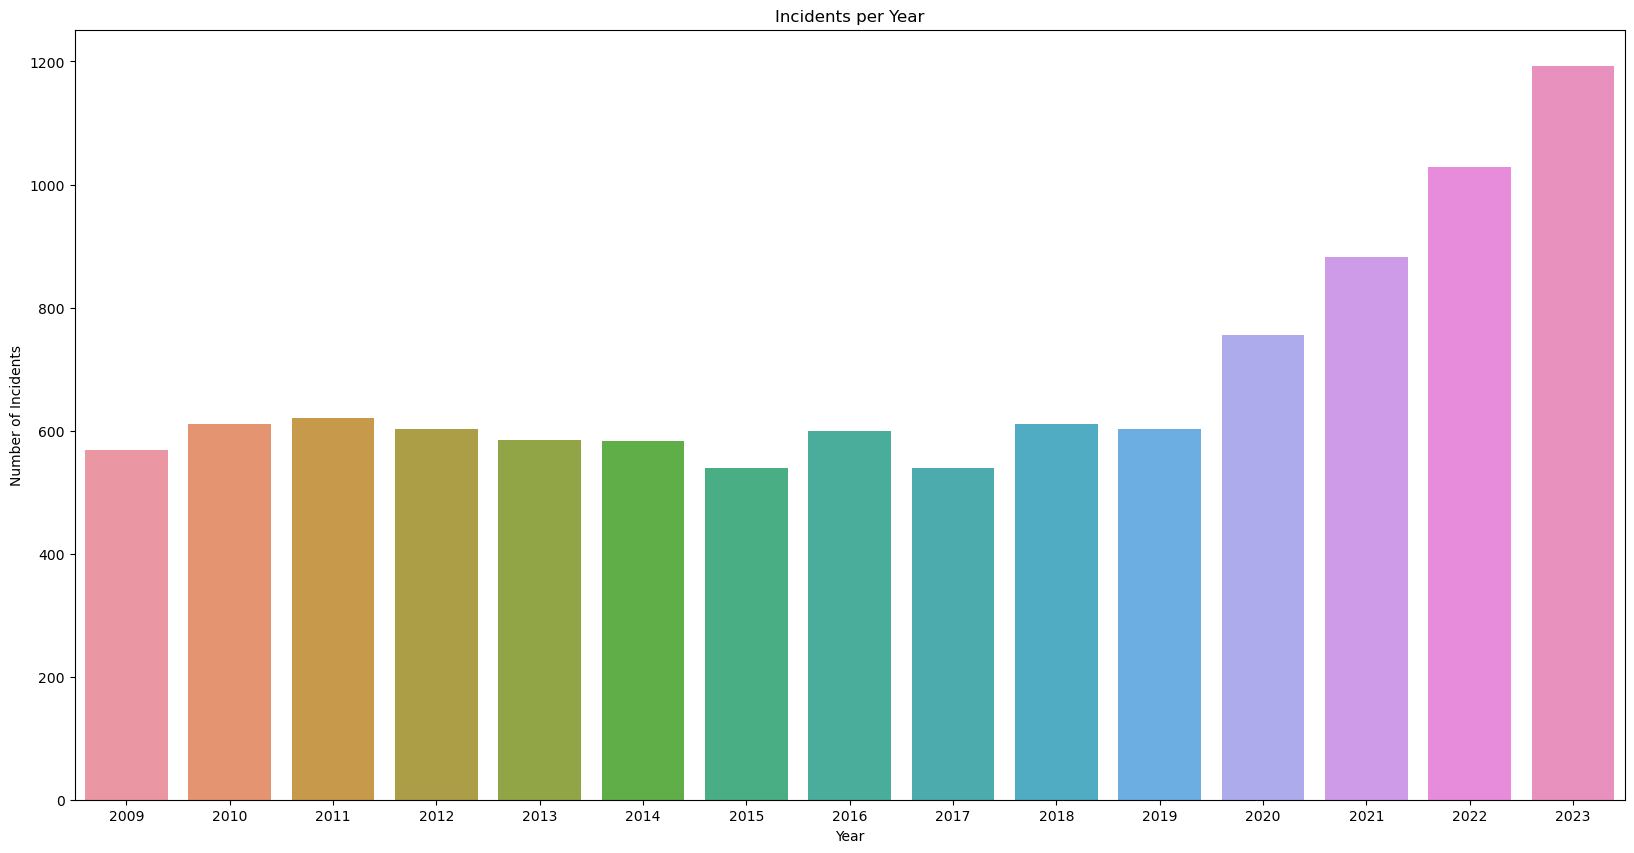

In [39]:
# Simple bar chart showing rescues against year
plt.figure(figsize=(20, 10))
sns.barplot(x=incidents_per_year.index, y=incidents_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Incidents per Year')
plt.show()

In [40]:
# Grouping by Year and Animal to get a pivot
pivot_year_animal = eda_lfb.groupby(['Year', 'Animal']).size().unstack(fill_value=0)
pivot_year_animal

Animal,Bird,Budgie,Bull,Cat,Cow,Deer,Dog,Ferret,Fish,Fox,Goat,Hamster,Hedgehog,Horse,Lamb,Lizard,Pigeon,Rabbit,Sheep,Snake,Squirrel,Tortoise,Unknown - Animal rescue from below ground - Farm animal,Unknown - Animal rescue from water - Farm animal,Unknown - Domestic Animal Or Pet,Unknown - Heavy Livestock Animal,Unknown - Wild Animal,cat
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009,89,0,0,262,0,8,132,0,0,16,0,0,1,19,0,1,0,1,1,3,4,0,0,0,10,14,6,1
2010,99,0,1,294,2,9,122,0,2,17,0,3,0,15,1,1,0,2,0,0,5,0,0,0,18,15,2,3
2011,120,1,0,309,0,9,103,2,0,26,0,3,0,22,0,0,0,0,0,0,4,0,0,0,13,8,0,0
2012,112,0,0,302,3,7,100,1,0,14,0,0,0,28,1,0,0,0,1,0,4,0,0,1,18,4,4,3
2013,85,0,0,312,0,7,93,0,0,25,0,3,0,16,0,0,1,0,0,2,7,0,0,0,19,2,12,1
2014,110,0,0,295,1,5,90,0,0,22,1,1,0,12,0,0,1,3,0,0,2,0,0,1,29,0,7,3
2015,106,0,0,262,0,6,88,1,0,21,0,0,0,12,0,0,0,0,1,0,5,1,0,0,29,0,7,1
2016,119,0,0,295,1,14,105,0,0,29,0,4,0,12,0,0,0,2,1,1,3,0,0,0,8,0,5,1
2017,124,0,0,257,0,11,81,0,0,33,0,0,0,10,0,0,1,0,0,1,5,0,0,0,8,0,7,1


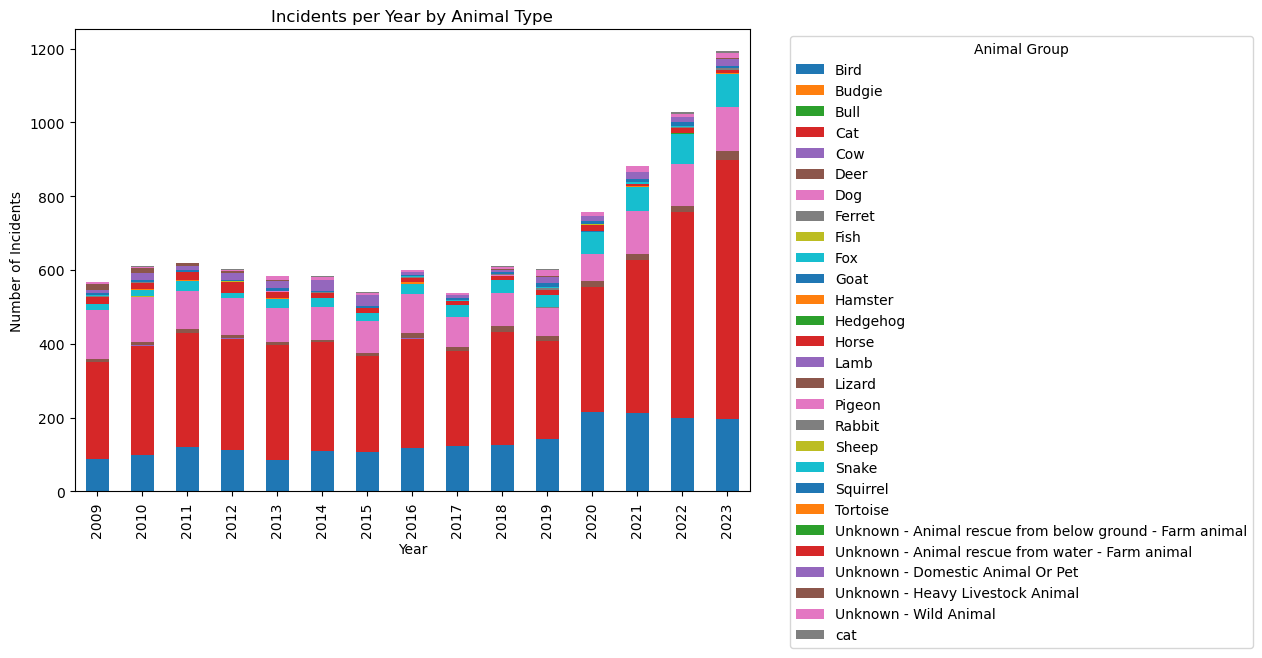

In [41]:
animals_by_year = pivot_year_animal.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Incidents per Year by Animal Type')
animals_by_year.legend(title='Animal Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.8)
plt.show()

Okay - there's a small percentage of values in Animal recorded as lowercase "cat".
I'll have those added to the uppercase "Cat" total.

In [42]:
eda_lfb["Animal"] = eda_lfb["Animal"].replace("cat", "Cat")
pivot_year_animal = eda_lfb.groupby(['Year', 'Animal']).size().unstack(fill_value=0)

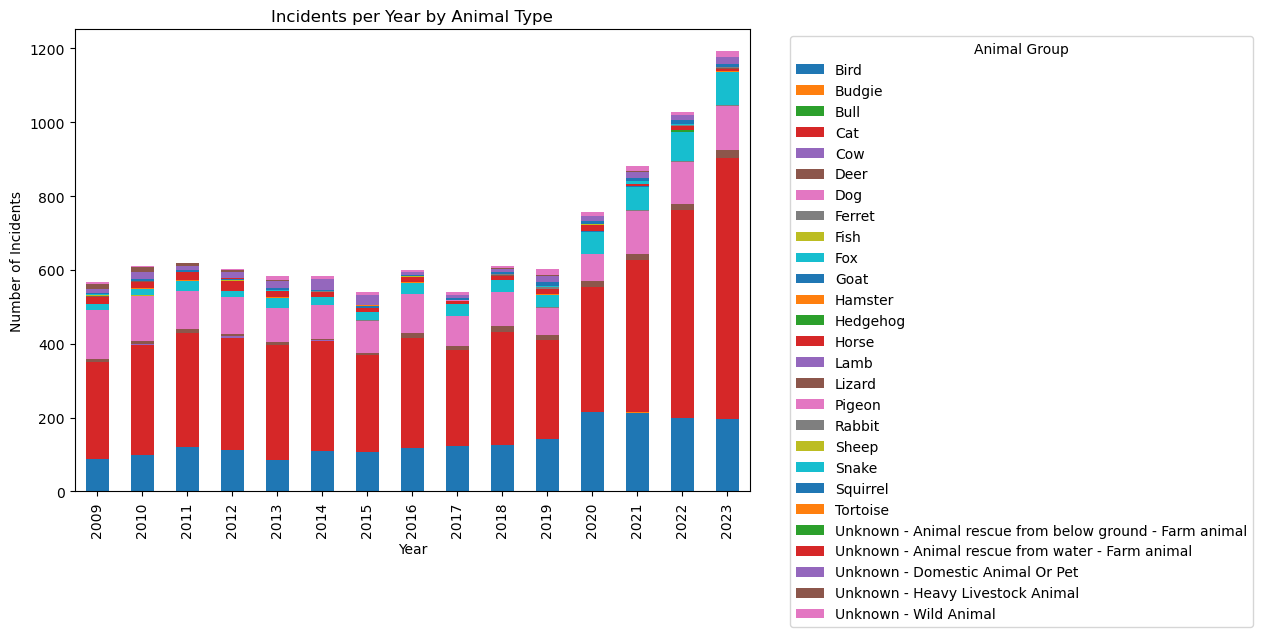

In [43]:
animals_by_year = pivot_year_animal.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Incidents per Year by Animal Type')
animals_by_year.legend(title='Animal Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.8)
plt.show()

That's great - we consolidated those values to a single column.

Moving on, let's try and visualize the frequency of the incidents on a monthly basis.

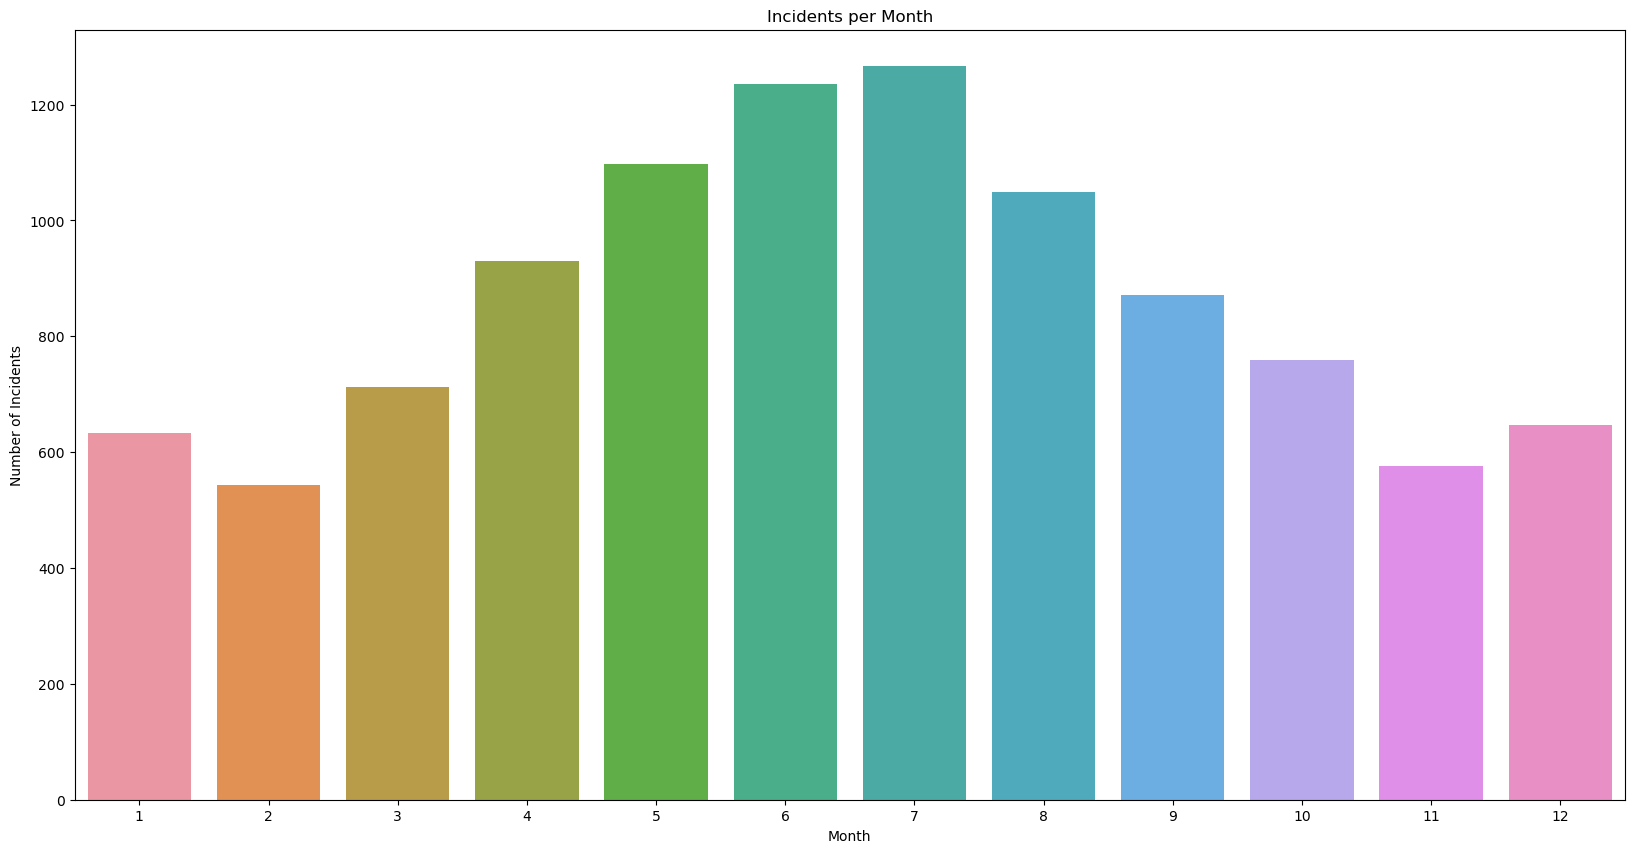

In [44]:
#Simple barchart showing animal incidents by month
incidents_by_month = eda_lfb.groupby("Month").size()
plt.figure(figsize=(20, 10))
sns.barplot(x=incidents_by_month.index, y=incidents_by_month.values)
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.title('Incidents per Month')
plt.show()

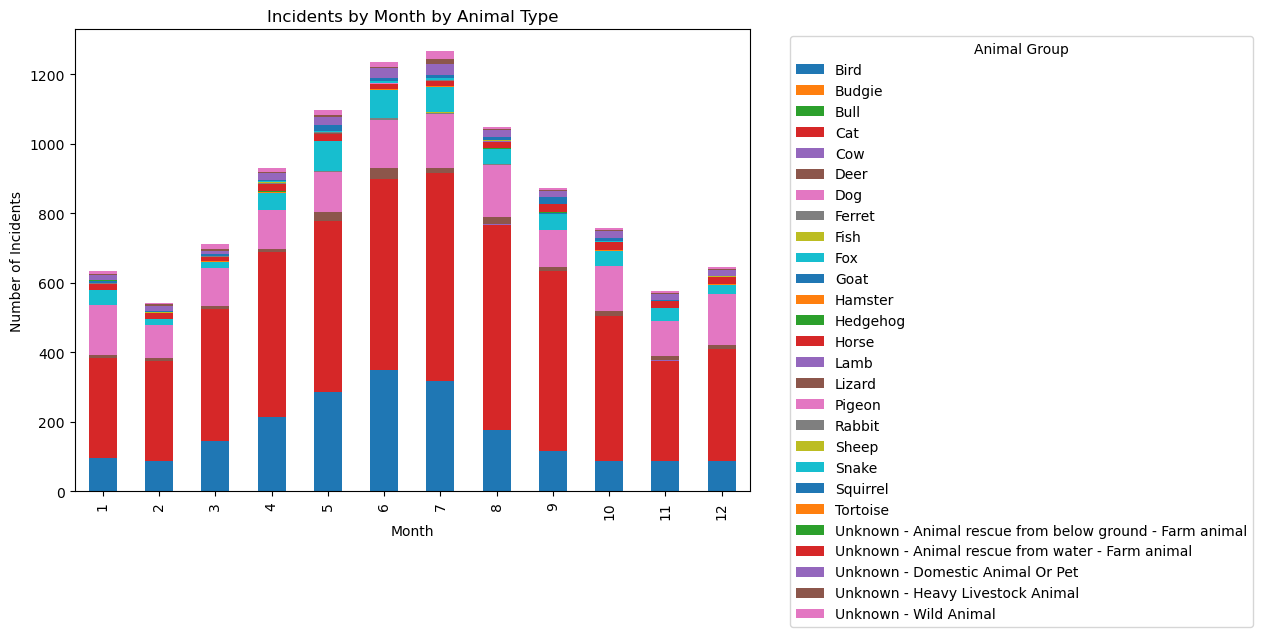

In [45]:
#Adding a species as a pivot
pivot_by_animal_month = eda_lfb.groupby(['Month', 'Animal']).size().unstack(fill_value=0)
animals_by_month = pivot_by_animal_month.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.title('Incidents by Month by Animal Type')
animals_by_month.legend(title='Animal Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.8)
plt.show()

A simple count plot of incidents by Boroughs and PropertyCategory

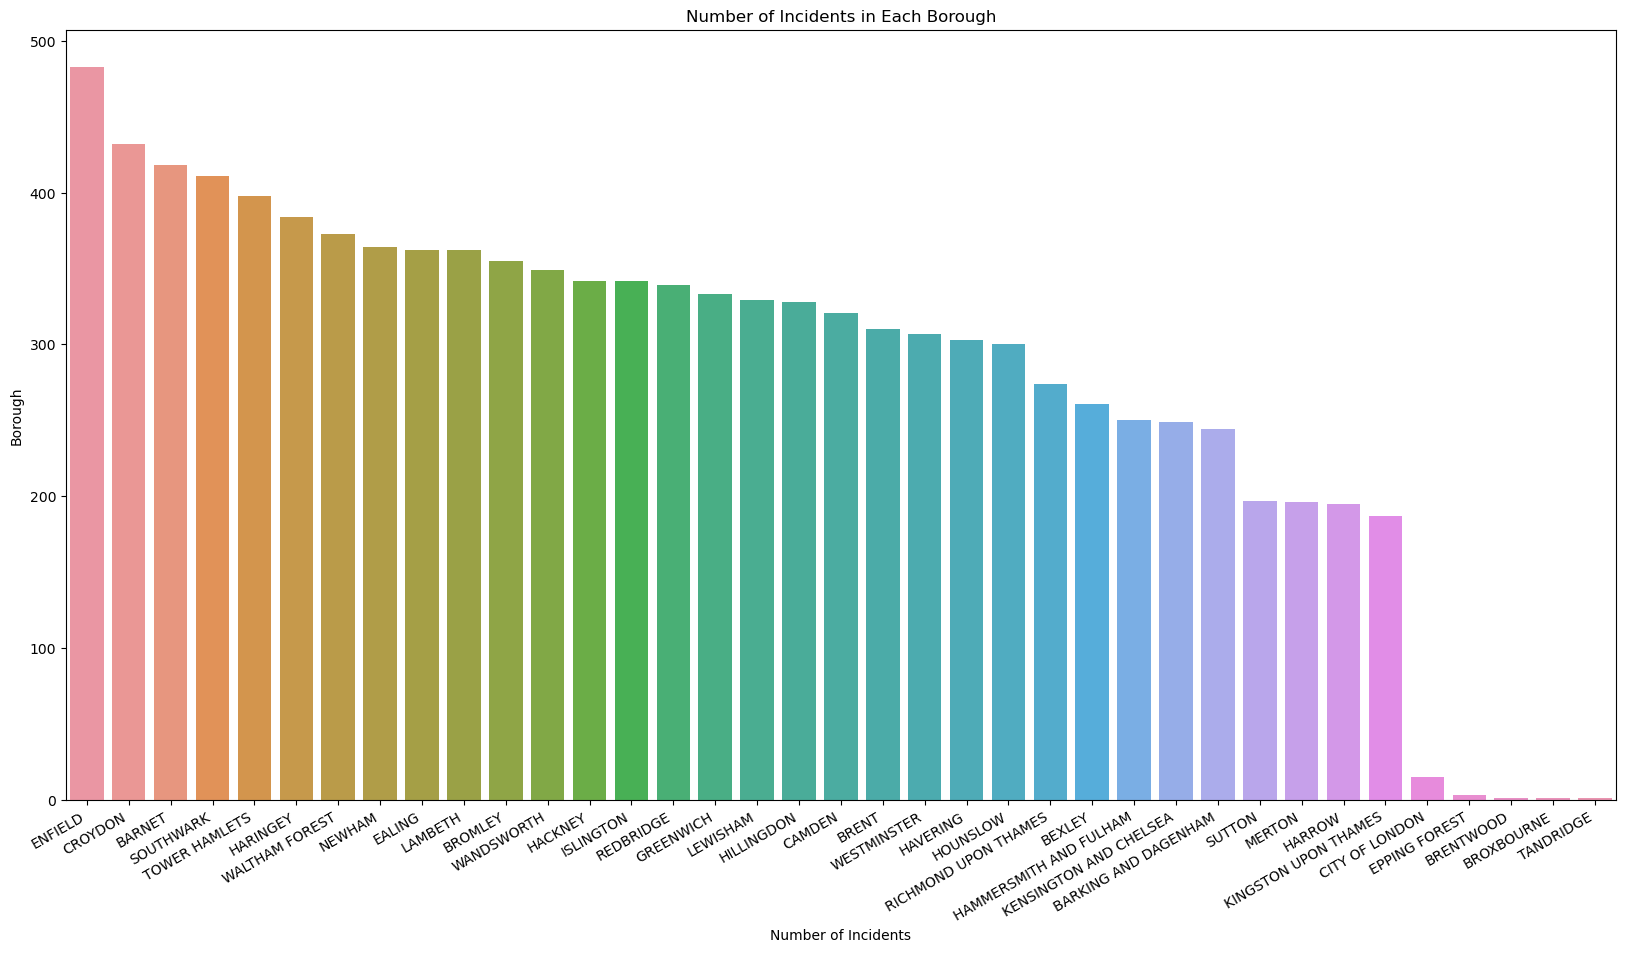

In [46]:
#Borough
plt.figure(figsize=(20, 10))
sns.countplot(x='Borough', 
              data=eda_lfb, 
              order = eda_lfb['Borough'].value_counts().index) #sorted in descending order

#Title and labels
plt.title('Number of Incidents in Each Borough')
plt.xlabel('Number of Incidents')
plt.ylabel('Borough')
plt.xticks(rotation=30,ha="right") # rotates the angle of the x-label by 30 degrees anticlockwise, 
plt.show()

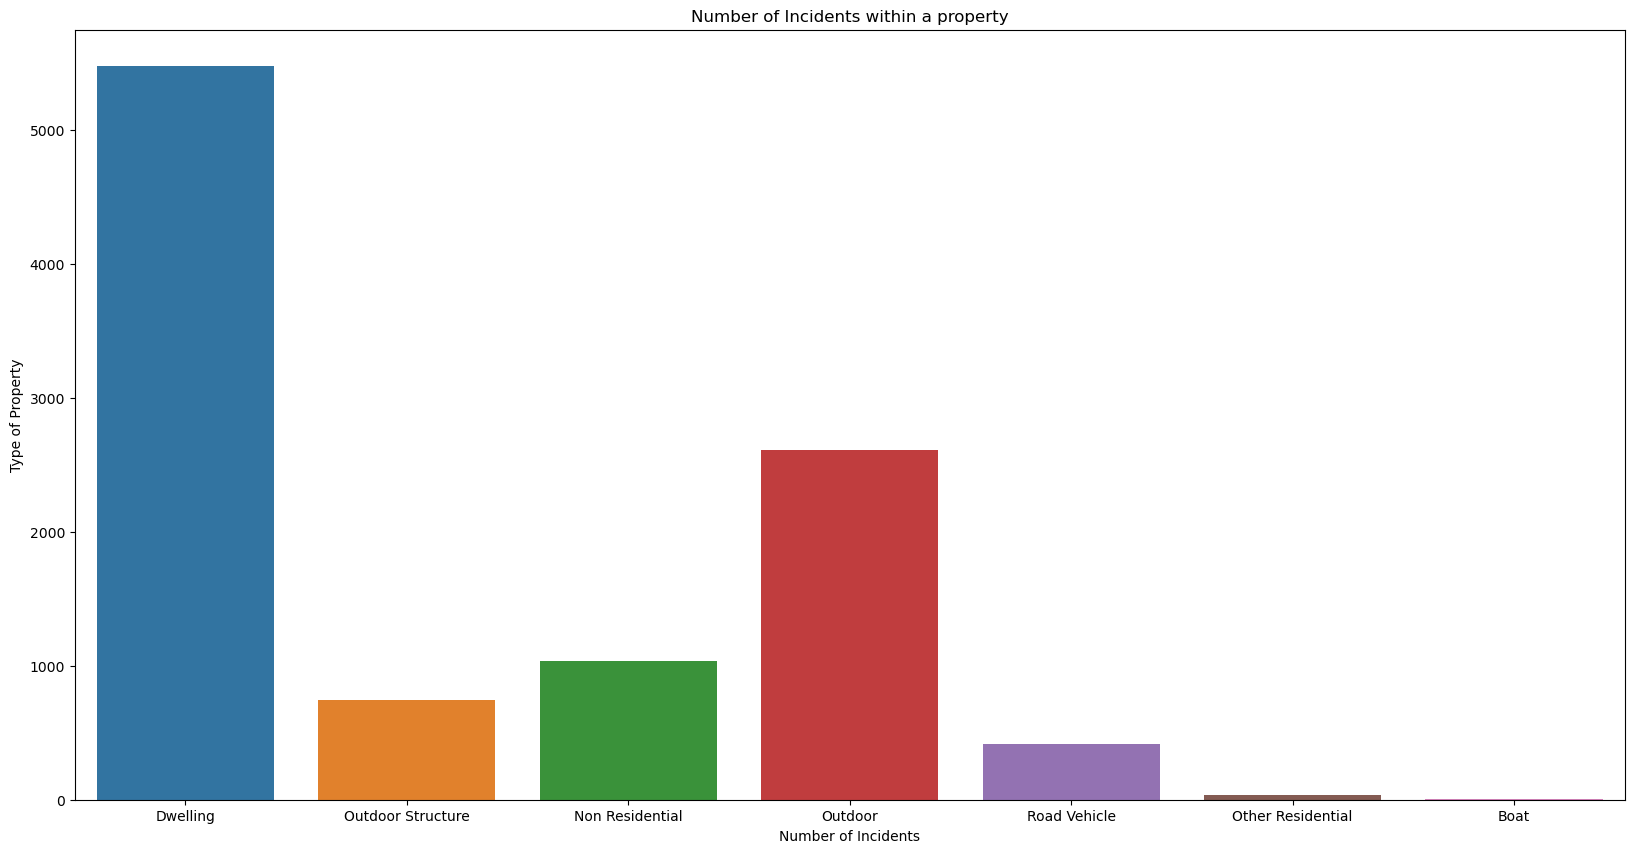

In [47]:
#By PropertyCategory
plt.figure(figsize=(20, 10))
sns.countplot(x='PropertyCategory', 
              data=eda_lfb)

#Title and labels
plt.title('Number of Incidents within a property')
plt.xlabel('Number of Incidents')
plt.ylabel('Type of Property')
plt.show()

### KNN and Feature Selection <a name="knn"></a> [back to Index](#top)

For feature selection, I want to start with a very small set of columns and values. 
My hypothesis: we can predict the animal species based on the Month to some degree of accuracy(?)

Click on this link to jump down to KNN summary [KNN Summary](#knn_summary)

For the first iteration, we'll use KNN with one feature column - Month

In [48]:
#Selecting one feature
feature_cols = ["Month"]
X = eda_lfb[feature_cols]
X.shape

(10319, 1)

Now, we have Animal which are individual categories or labels. I'll use one-hot encoding to transform the values to numerical values.

In [49]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

In [50]:
#perform one-hot encoding on 'Animal' column 
encoder_df = pd.DataFrame(encoder.fit_transform(eda_lfb[['Animal']]).toarray())
encoder_df.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
9522,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4079,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9924,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4992,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8472,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2252,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1928,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5364,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
encoder_df.shape

(10319, 27)

In [52]:
knn_lfb = eda_lfb.join(encoder_df)
knn_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
1715,Dog,Dwelling,BEXLEY,1.0,2011-10-29 19:03:00,10,2011-10-29,19:03:00,2011,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10132,Bird,Outdoor Structure,TOWER HAMLETS,1.0,2023-10-06 16:42:00,10,2023-10-06,16:42:00,2023,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6172,Fox,Outdoor,ENFIELD,1.0,2019-07-02 07:13:00,7,2019-07-02,07:13:00,2019,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9000,Horse,Outdoor,ENFIELD,1.0,2022-10-24 08:20:00,10,2022-10-24,08:20:00,2022,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5693,Dog,Dwelling,HILLINGDON,1.0,2018-08-25 22:15:00,8,2018-08-25,22:15:00,2018,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3123,Bird,Non Residential,WESTMINSTER,1.0,2014-04-13 15:38:00,4,2014-04-13,15:38:00,2014,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2779,Dog,Outdoor,RICHMOND UPON THAMES,1.0,2013-08-01 10:28:00,8,2013-08-01,10:28:00,2013,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3249,Cat,Dwelling,SOUTHWARK,1.0,2014-06-16 01:00:00,6,2014-06-16,01:00:00,2014,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8734,Cat,Non Residential,TOWER HAMLETS,1.0,2022-07-25 22:45:00,7,2022-07-25,22:45:00,2022,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7695,Bird,Dwelling,LAMBETH,1.0,2021-07-04 11:53:00,7,2021-07-04,11:53:00,2021,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
knn_lfb.shape

(10319, 36)

Okay - that's a lot of columns to go into. Probably **not a good idea** to use one-hot encoding...

Let's use a Label Encoder instead

In [54]:
label_encoder = LabelEncoder()
eda_lfb['Animal_encoded'] = label_encoder.fit_transform(eda_lfb['Animal'])

# Select feature and target
X = eda_lfb[['Month']]  # Feature
y = eda_lfb['Animal_encoded']  # Target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Implementing KNN
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.08      0.12       635
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.49      0.83      0.62      1532
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        53
           6       0.11      0.06      0.08       489
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00       160
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00        63
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         3
          18       0.00    

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Okay - that doesn't really help us a lot. Some ideas to ponder and implement moving forward:
- Use PropertyCategory as a Feature col (combine with Month)??
- group the animals into a shorter list of categories (e.g Pets, Farm Animals, Wildlife, Fish)
- Pump is a numeric, maybe check if we can use linear regression to predict the number of Pumps needed based on dwelling and month?

Using Month and Property Category as feature columns

In [55]:
eda_lfb['PropertyCategory_encoded'] = label_encoder.fit_transform(eda_lfb['PropertyCategory'])
eda_lfb['Animal_encoded'] = label_encoder.fit_transform(eda_lfb['Animal'])

# Select features and target
X = eda_lfb[['Month', 'PropertyCategory_encoded']] #Features
y = eda_lfb['Animal_encoded'] #Target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Implementing KNN
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.27      0.25       635
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.54      0.75      0.63      1532
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        53
           6       0.32      0.18      0.23       489
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00       160
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00        63
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         3
          18       0.00    

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Pausing the modelling for now... 
A little bit of more EDA needed.

##### A little bit more EDA...

In [56]:
eda_lfb

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,Animal_encoded,PropertyCategory_encoded
0,Dog,Dwelling,CROYDON,1.0,2009-01-01 03:01:00,1,2009-01-01,03:01:00,2009,6,1
1,Fox,Outdoor Structure,CROYDON,1.0,2009-01-01 08:51:00,1,2009-01-01,08:51:00,2009,9,5
2,Dog,Outdoor Structure,SUTTON,1.0,2009-01-04 10:07:00,1,2009-01-04,10:07:00,2009,6,5
3,Horse,Non Residential,HILLINGDON,1.0,2009-01-05 12:27:00,1,2009-01-05,12:27:00,2009,13,2
4,Rabbit,Dwelling,HAVERING,1.0,2009-01-06 15:23:00,1,2009-01-06,15:23:00,2009,17,1
...,...,...,...,...,...,...,...,...,...,...,...
10327,Cat,Dwelling,BRENT,1.0,2023-12-30 13:23:00,12,2023-12-30,13:23:00,2023,3,1
10328,Cat,Dwelling,SOUTHWARK,1.0,2023-12-30 19:44:00,12,2023-12-30,19:44:00,2023,3,1
10329,Cat,Dwelling,ENFIELD,1.0,2023-12-31 12:08:00,12,2023-12-31,12:08:00,2023,3,1
10330,Fox,Dwelling,BRENT,1.0,2023-12-31 15:57:00,12,2023-12-31,15:57:00,2023,9,1


In [57]:
#restoring the original columns
eda_lfb.drop(["Animal_encoded", "PropertyCategory_encoded"], axis=1, inplace=True)
eda_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year
5122,Bird,Outdoor,BARNET,1.0,2017-09-03 06:35:00,9,2017-09-03,06:35:00,2017
7653,Bird,Outdoor,KENSINGTON AND CHELSEA,1.0,2021-06-22 18:08:00,6,2021-06-22,18:08:00,2021
3273,Cat,Dwelling,NEWHAM,1.0,2014-06-22 21:14:00,6,2014-06-22,21:14:00,2014
9811,Cat,Dwelling,SOUTHWARK,1.0,2023-07-20 23:31:00,7,2023-07-20,23:31:00,2023
1048,Dog,Outdoor,REDBRIDGE,1.0,2010-09-24 16:43:00,9,2010-09-24,16:43:00,2010
425,Horse,Outdoor,BEXLEY,2.0,2009-09-02 10:57:00,9,2009-09-02,10:57:00,2009
8823,Cat,Dwelling,GREENWICH,1.0,2022-08-21 17:06:00,8,2022-08-21,17:06:00,2022
4296,Cat,Dwelling,EALING,1.0,2016-05-21 16:58:00,5,2016-05-21,16:58:00,2016
6948,Dog,Road Vehicle,BRENT,1.0,2020-08-11 10:25:00,8,2020-08-11,10:25:00,2020
775,Cat,Outdoor,ISLINGTON,1.0,2010-05-10 12:43:00,5,2010-05-10,12:43:00,2010


In [58]:
#running column analyzer on Animal
column_analyzer(eda_lfb["Animal"])

The data type is object
The unique value count for is 27
The unique values are  ['Dog' 'Fox' 'Horse' 'Rabbit' 'Unknown - Heavy Livestock Animal'
 'Squirrel' 'Cat' 'Bird' 'Unknown - Domestic Animal Or Pet' 'Sheep' 'Deer'
 'Unknown - Wild Animal' 'Snake' 'Lizard' 'Hedgehog' 'Hamster' 'Lamb'
 'Fish' 'Bull' 'Cow' 'Ferret' 'Budgie'
 'Unknown - Animal rescue from water - Farm animal' 'Pigeon' 'Goat'
 'Tortoise' 'Unknown - Animal rescue from below ground - Farm animal']
The null count is 0


In [59]:
# Getting a sorted value count for all Animals
sorted_animal_count = eda_lfb["Animal"].value_counts()
sorted_animal_count

Cat                                                        5199
Bird                                                       2053
Dog                                                        1502
Fox                                                         562
Unknown - Domestic Animal Or Pet                            238
Horse                                                       213
Deer                                                        177
Unknown - Wild Animal                                       118
Squirrel                                                     89
Unknown - Heavy Livestock Animal                             51
Rabbit                                                       20
Hamster                                                      20
Snake                                                        20
Ferret                                                       11
Cow                                                           9
Sheep                                   

Grouping the animals into a larger supersets should probably help a bit. Let's group them into the following:

1. Pets - Cat, Dog, Rabbit, Budgie, Unknown - Domestic Animal or Pet, Hamster, Ferret

2. Farm_animals - Horse, Unknown - Heavy Livestock Animal, Cow, Sheep, Goat, Unknown - Animal rescue from water - Farm animal, Lamb, Bull, Unknown - Animal rescue from below ground - Farm animal, Tortoise

3. Birds - Bird, Pigeon

4. Wild_animals - Fox, Deer, Unknown - Wild Animal, Squirrel, Snake, Hedgehog, Lizard, Fish

In [60]:
#Applying custom function to Animal column
eda_lfb["AnimalCategory"] = eda_lfb["Animal"].apply(categorize_animaltype)
eda_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,AnimalCategory
6974,Cat,Outdoor,HARROW,1.0,2020-08-20 06:36:00,8,2020-08-20,06:36:00,2020,Pets
3710,Sheep,Outdoor,ENFIELD,1.0,2015-04-29 15:10:00,4,2015-04-29,15:10:00,2015,Farm_animals
2536,Unknown - Heavy Livestock Animal,Dwelling,BROMLEY,2.0,2013-04-15 11:27:00,4,2013-04-15,11:27:00,2013,Farm_animals
5140,Cat,Dwelling,BROMLEY,1.0,2017-09-16 17:12:00,9,2017-09-16,17:12:00,2017,Pets
454,Cat,Dwelling,NEWHAM,1.0,2009-09-22 13:21:00,9,2009-09-22,13:21:00,2009,Pets
8751,Cat,Dwelling,WANDSWORTH,1.0,2022-07-31 06:49:00,7,2022-07-31,06:49:00,2022,Pets
1554,Cat,Road Vehicle,ISLINGTON,1.0,2011-07-31 11:12:00,7,2011-07-31,11:12:00,2011,Pets
4499,Dog,Outdoor Structure,EALING,1.0,2016-08-20 15:13:00,8,2016-08-20,15:13:00,2016,Pets
5755,Cat,Dwelling,CAMDEN,1.0,2018-10-02 04:59:00,10,2018-10-02,04:59:00,2018,Pets
4785,Cat,Dwelling,HARINGEY,1.0,2017-03-01 20:29:00,3,2017-03-01,20:29:00,2017,Pets


In [61]:
#Checking animalcategory counts
animalcategory_count = eda_lfb["AnimalCategory"].value_counts()
animalcategory_count

Pets            6755
Birds           2058
Wild_animals     977
Farm_animals     291
Others           238
Name: AnimalCategory, dtype: int64

Grouping the boroughs further into SubRegions of London as below (source - https://en.wikipedia.org/wiki/List_of_sub-regions_used_in_the_London_Plan):
	
1. Central - Camden, City of London, Kensington and Chelsea, Islington, Lambeth, Southwark, Westminster 
2. East - Barking and Dagenham, Bexley, Greenwich, Hackney, Havering, Lewisham, Newham, Redbridge, Tower Hamlets, Waltham Forest
3. North - Barnet, Enfield, Haringey
4. South - Bromley, Croydon, Kingston upon Thames, Merton, Sutton, Wandsworth
5. West - Brent, Ealing, Hammersmith and Fulham, Harrow, Richmond upon Thames, Hillingdon, Hounslow


In [62]:
#Applying custom function to Borough column
eda_lfb["Subregion"] = eda_lfb["Borough"].apply(subregion)
eda_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,AnimalCategory,Subregion
1056,Dog,Dwelling,HACKNEY,1.0,2010-09-30 09:35:00,9,2010-09-30,09:35:00,2010,Pets,East
3745,Bird,Non Residential,RICHMOND UPON THAMES,1.0,2015-05-16 13:10:00,5,2015-05-16,13:10:00,2015,Birds,West
9291,Unknown - Domestic Animal Or Pet,Outdoor,WALTHAM FOREST,1.0,2023-03-15 19:43:00,3,2023-03-15,19:43:00,2023,Others,East
8237,Bird,Non Residential,SUTTON,1.0,2022-03-09 17:25:00,3,2022-03-09,17:25:00,2022,Birds,South
2377,Cat,Outdoor Structure,ENFIELD,1.0,2012-12-13 22:30:00,12,2012-12-13,22:30:00,2012,Pets,North
3985,Cat,Dwelling,HARINGEY,1.0,2015-09-14 17:18:00,9,2015-09-14,17:18:00,2015,Pets,North
4654,Bird,Outdoor Structure,BRENT,1.0,2016-11-17 12:31:00,11,2016-11-17,12:31:00,2016,Birds,West
6563,Bird,Non Residential,HARINGEY,1.0,2020-03-12 18:37:00,3,2020-03-12,18:37:00,2020,Birds,North
10050,Cat,Dwelling,HAVERING,1.0,2023-09-15 07:52:00,9,2023-09-15,07:52:00,2023,Pets,East
7521,Cat,Dwelling,HARINGEY,1.0,2021-05-24 05:04:00,5,2021-05-24,05:04:00,2021,Pets,North


In [63]:
column_analyzer(eda_lfb["Subregion"])

The data type is object
The unique value count for is 6
The unique values are  ['South' 'West' 'East' 'Central' 'North' 'Outside London']
The null count is 0


In [64]:
subregions_count = eda_lfb["Subregion"].value_counts()
subregions_count

East              3286
West              2019
Central           2007
South             1716
North             1285
Outside London       6
Name: Subregion, dtype: int64

#### knn take 2

We've now grouped everything into larger super-groups, to try and reduce cardinality - Animal to AnimalCategory, Borough to Subregion.
let's try knn again with the following features:
X as PropertyCategory and Subregion
Y as AnimalCategory

In [65]:
eda_lfb['PropertyCategory_encoded'] = label_encoder.fit_transform(eda_lfb['PropertyCategory'])
eda_lfb['AnimalCategory_encoded'] = label_encoder.fit_transform(eda_lfb['AnimalCategory'])
eda_lfb['Subregion_encoded'] = label_encoder.fit_transform(eda_lfb['Subregion'])
eda_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,AnimalCategory,Subregion,PropertyCategory_encoded,AnimalCategory_encoded,Subregion_encoded
5364,Cat,Outdoor,GREENWICH,1.0,2018-04-11 21:06:00,4,2018-04-11,21:06:00,2018,Pets,East,4,3,1
4535,Cat,Dwelling,WESTMINSTER,1.0,2016-09-09 17:16:00,9,2016-09-09,17:16:00,2016,Pets,Central,1,3,0
1338,Cat,Outdoor,ISLINGTON,1.0,2011-04-28 19:05:00,4,2011-04-28,19:05:00,2011,Pets,Central,4,3,0
375,Cat,Dwelling,ISLINGTON,1.0,2009-08-03 10:04:00,8,2009-08-03,10:04:00,2009,Pets,Central,1,3,0
1530,Cat,Dwelling,NEWHAM,1.0,2011-07-18 17:25:00,7,2011-07-18,17:25:00,2011,Pets,East,1,3,1
10145,Cat,Outdoor,BRENT,1.0,2023-10-10 09:15:00,10,2023-10-10,09:15:00,2023,Pets,West,4,3,5
9919,Dog,Road Vehicle,NEWHAM,1.0,2023-08-15 14:19:00,8,2023-08-15,14:19:00,2023,Pets,East,6,3,1
497,Cat,Dwelling,WESTMINSTER,1.0,2009-10-24 06:51:00,10,2009-10-24,06:51:00,2009,Pets,Central,1,3,0
2032,Dog,Outdoor Structure,SOUTHWARK,1.0,2012-05-26 06:01:00,5,2012-05-26,06:01:00,2012,Pets,Central,5,3,0
701,Cat,Outdoor,SUTTON,1.0,2010-04-02 15:04:00,4,2010-04-02,15:04:00,2010,Pets,South,4,3,4


In [66]:
print(eda_lfb[['Subregion', 'Subregion_encoded']].drop_duplicates().reset_index(drop=True))
print(eda_lfb[['PropertyCategory', 'PropertyCategory_encoded']].drop_duplicates().reset_index(drop=True))
print(eda_lfb[['AnimalCategory', 'AnimalCategory_encoded']].drop_duplicates().reset_index(drop=True))

        Subregion  Subregion_encoded
0           South                  4
1            West                  5
2            East                  1
3         Central                  0
4           North                  2
5  Outside London                  3
    PropertyCategory  PropertyCategory_encoded
0           Dwelling                         1
1  Outdoor Structure                         5
2    Non Residential                         2
3            Outdoor                         4
4       Road Vehicle                         6
5  Other Residential                         3
6               Boat                         0
  AnimalCategory  AnimalCategory_encoded
0           Pets                       3
1   Wild_animals                       4
2   Farm_animals                       1
3          Birds                       0
4         Others                       2


In [67]:
# Select features and target
X = eda_lfb[['Subregion_encoded', 'PropertyCategory_encoded']]
y = eda_lfb['AnimalCategory_encoded']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Implementing KNN
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=85) #Square root of 75% of 10319 records, empirical check
knn.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.08      0.12       531
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        57
           3       0.66      0.97      0.78      1677
           4       0.00      0.00      0.00       247

    accuracy                           0.64      2580
   macro avg       0.19      0.21      0.18      2580
weighted avg       0.49      0.64      0.54      2580



/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [68]:
#Using only sub-region
X = eda_lfb[['Subregion_encoded']]
y = eda_lfb['AnimalCategory_encoded']

# Step 2: Implementing KNN
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=85) #Square root of 70% of 10319 records, empirical check
knn.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       531
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        57
           3       0.65      1.00      0.79      1677
           4       0.00      0.00      0.00       247

    accuracy                           0.65      2580
   macro avg       0.13      0.20      0.16      2580
weighted avg       0.42      0.65      0.51      2580



/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [69]:
#Keeping Subregion and PropertyCategory as features, we'll try cross-validation
#Cross-validation
X = eda_lfb[['Subregion_encoded', 'PropertyCategory_encoded']]
y = eda_lfb['AnimalCategory_encoded']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Implementing KNN
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

neighbors = list(range(1, 86))  #Range from 1 to empirical n value
cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')  # Using 5-fold CV
    cv_scores.append(scores.mean())

# Find the optimal k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print("The optimal number of neighbors is:", optimal_k)

The optimal number of neighbors is: 28


In [70]:
#Running KNN with the optimal_k value
X = eda_lfb[['Subregion_encoded', 'PropertyCategory_encoded']]
y = eda_lfb['AnimalCategory_encoded']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Implementing KNN
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

#Classification report at this k-value
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.10      0.15       636
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00        65
           3       0.67      0.97      0.79      2031
           4       0.00      0.00      0.00       280

    accuracy                           0.66      3096
   macro avg       0.21      0.21      0.19      3096
weighted avg       0.52      0.66      0.55      3096



/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



At this point, it's pretty evident that the model can predict 3 = Pets to an extent, based on the selected Features (Property and Subregion). However, it's not possible to predict the other AnimalCategory values - purely because Pets is the most dominant value in the entire series.

This will be a bit academic, but for next steps, we'll group the AnimalCategory further into a new column as Pets where if the answer is yes, then it's a 1 else the value will be a 0.

In [71]:
eda_lfb

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,AnimalCategory,Subregion,PropertyCategory_encoded,AnimalCategory_encoded,Subregion_encoded
0,Dog,Dwelling,CROYDON,1.0,2009-01-01 03:01:00,1,2009-01-01,03:01:00,2009,Pets,South,1,3,4
1,Fox,Outdoor Structure,CROYDON,1.0,2009-01-01 08:51:00,1,2009-01-01,08:51:00,2009,Wild_animals,South,5,4,4
2,Dog,Outdoor Structure,SUTTON,1.0,2009-01-04 10:07:00,1,2009-01-04,10:07:00,2009,Pets,South,5,3,4
3,Horse,Non Residential,HILLINGDON,1.0,2009-01-05 12:27:00,1,2009-01-05,12:27:00,2009,Farm_animals,West,2,1,5
4,Rabbit,Dwelling,HAVERING,1.0,2009-01-06 15:23:00,1,2009-01-06,15:23:00,2009,Pets,East,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10327,Cat,Dwelling,BRENT,1.0,2023-12-30 13:23:00,12,2023-12-30,13:23:00,2023,Pets,West,1,3,5
10328,Cat,Dwelling,SOUTHWARK,1.0,2023-12-30 19:44:00,12,2023-12-30,19:44:00,2023,Pets,Central,1,3,0
10329,Cat,Dwelling,ENFIELD,1.0,2023-12-31 12:08:00,12,2023-12-31,12:08:00,2023,Pets,North,1,3,2
10330,Fox,Dwelling,BRENT,1.0,2023-12-31 15:57:00,12,2023-12-31,15:57:00,2023,Wild_animals,West,1,4,5


In [72]:
#Running a simple if-else within a lambda
eda_lfb['Pets'] = eda_lfb['AnimalCategory'].apply(lambda x: 1 if x == "Pets" else 0)
eda_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,AnimalCategory,Subregion,PropertyCategory_encoded,AnimalCategory_encoded,Subregion_encoded,Pets
880,Cat,Dwelling,WALTHAM FOREST,1.0,2010-06-27 12:01:00,6,2010-06-27,12:01:00,2010,Pets,East,1,3,1,1
6578,Bird,Dwelling,CROYDON,1.0,2020-03-23 11:16:00,3,2020-03-23,11:16:00,2020,Birds,South,1,0,4,0
7145,Cow,Outdoor,CROYDON,1.0,2020-11-22 08:42:00,11,2020-11-22,08:42:00,2020,Farm_animals,South,4,1,4,0
6254,Cat,Outdoor,HAVERING,1.0,2019-08-01 09:38:00,8,2019-08-01,09:38:00,2019,Pets,East,4,3,1,1
908,Cat,Non Residential,LAMBETH,1.0,2010-07-09 20:50:00,7,2010-07-09,20:50:00,2010,Pets,Central,2,3,0,1
4301,Dog,Outdoor,HARROW,1.0,2016-05-24 12:44:00,5,2016-05-24,12:44:00,2016,Pets,West,4,3,5,1
1268,Dog,Outdoor,LAMBETH,0.0,2011-03-26 09:53:00,3,2011-03-26,09:53:00,2011,Pets,Central,4,3,0,1
8143,Dog,Dwelling,BARNET,1.0,2022-01-20 23:12:00,1,2022-01-20,23:12:00,2022,Pets,North,1,3,2,1
2402,Unknown - Wild Animal,Non Residential,MERTON,1.0,2013-01-01 14:22:00,1,2013-01-01,14:22:00,2013,Wild_animals,South,2,4,4,0
7761,Bird,Outdoor Structure,LEWISHAM,1.0,2021-07-24 14:20:00,7,2021-07-24,14:20:00,2021,Birds,East,5,0,1,0


In [73]:
#running KNN with feature columns Subregion, Property and target as Pets
X = eda_lfb[['Subregion_encoded', 'PropertyCategory_encoded']]
y = eda_lfb['Pets']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Implementing KNN
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

#Classification report at this k-value
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.16      0.24       903
           1       0.67      0.93      0.78      1677

    accuracy                           0.66      2580
   macro avg       0.60      0.54      0.51      2580
weighted avg       0.62      0.66      0.59      2580



In [74]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 140,  763],
       [ 124, 1553]])

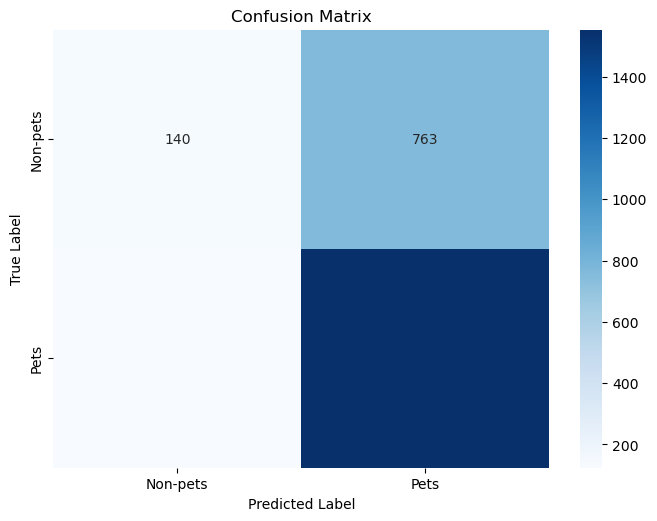

In [75]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-pets', 'Pets'], yticklabels=['Non-pets', 'Pets'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.subplots_adjust(bottom=0.15)
plt.show()

In [76]:
#Using plotly express instead
conmat = pd.DataFrame(conf_matrix, 
                  index=['Non-pets (Actual)', 'Pets (Actual)'],
                  columns=['Non-pets (Predicted)', 'Pets (Predicted)'])

# Create the heatmap
fig = px.imshow(conmat,
                labels=dict(x="Predicted Label", y="True Label", color="Count"),
                x=['Non-pets', 'Pets'],
                y=['Non-pets', 'Pets'],
                text_auto=True,  # Automatically set text in each cell to the count
                color_continuous_scale='Blues')  # Color scale

# Add titles
fig.update_layout(title_text='Confusion Matrix for Pets vs Non-Pets')

# Show the plot
fig.show()

### KNN Summary <a name="knn_summary"></a>

- For the final KNN model iteration, we chose Pets vs Non-Pets as the Target, and SubRegion and PropertyCategory as the Features.

- We used 5-fold cross validation to arrive at an optimal k-value = 28, with standard test/train ratio of 25/75, and random state=42.

- The model turns out to be significantly better at identifying Pets than non-pet incidents, with higher recall and F1-score for Pets. This is most likely due to a larger number of animals in the Pets category leading to a bias.

- The low recall for non-pets (0.16) and the data from the confusion matrix plot indicates that the model misses a large proportion of actual non-pet incidents. 

- Overall accuracy indicates that this model is correct for 66% of this dataset, but it doesn't account for the imbalance between the two groups.

- We can look into undersampling the Pets group vs non-Pets group, to see if this can be improved further.

- Alternatively, we can scale the knn modeling to only focus on the Animals in the Pets group.


## Time Series <a name="time"></a> [back to Index](#top)

As this data has timestamps, it makes sense to check to see if we have any trends with time-series forecasting.
Let's start with adding days of the week, and laying plots to look for any patterns

In [77]:
eda_lfb

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,AnimalCategory,Subregion,PropertyCategory_encoded,AnimalCategory_encoded,Subregion_encoded,Pets
0,Dog,Dwelling,CROYDON,1.0,2009-01-01 03:01:00,1,2009-01-01,03:01:00,2009,Pets,South,1,3,4,1
1,Fox,Outdoor Structure,CROYDON,1.0,2009-01-01 08:51:00,1,2009-01-01,08:51:00,2009,Wild_animals,South,5,4,4,0
2,Dog,Outdoor Structure,SUTTON,1.0,2009-01-04 10:07:00,1,2009-01-04,10:07:00,2009,Pets,South,5,3,4,1
3,Horse,Non Residential,HILLINGDON,1.0,2009-01-05 12:27:00,1,2009-01-05,12:27:00,2009,Farm_animals,West,2,1,5,0
4,Rabbit,Dwelling,HAVERING,1.0,2009-01-06 15:23:00,1,2009-01-06,15:23:00,2009,Pets,East,1,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10327,Cat,Dwelling,BRENT,1.0,2023-12-30 13:23:00,12,2023-12-30,13:23:00,2023,Pets,West,1,3,5,1
10328,Cat,Dwelling,SOUTHWARK,1.0,2023-12-30 19:44:00,12,2023-12-30,19:44:00,2023,Pets,Central,1,3,0,1
10329,Cat,Dwelling,ENFIELD,1.0,2023-12-31 12:08:00,12,2023-12-31,12:08:00,2023,Pets,North,1,3,2,1
10330,Fox,Dwelling,BRENT,1.0,2023-12-31 15:57:00,12,2023-12-31,15:57:00,2023,Wild_animals,West,1,4,5,0


In [78]:
eda_lfb.shape

(10319, 15)

In [79]:
eda_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,AnimalCategory,Subregion,PropertyCategory_encoded,AnimalCategory_encoded,Subregion_encoded,Pets
7256,Fox,Dwelling,BEXLEY,1.0,2021-01-26 23:35:00,1,2021-01-26,23:35:00,2021,Wild_animals,East,1,4,1,0
3462,Bird,Outdoor,HILLINGDON,2.0,2014-09-23 18:39:00,9,2014-09-23,18:39:00,2014,Birds,West,4,0,5,0
9182,Cat,Outdoor,WESTMINSTER,1.0,2023-01-24 13:57:00,1,2023-01-24,13:57:00,2023,Pets,Central,4,3,0,1
9093,Cat,Dwelling,BROMLEY,1.0,2022-12-04 18:48:00,12,2022-12-04,18:48:00,2022,Pets,South,1,3,4,1
7491,Bird,Non Residential,WESTMINSTER,1.0,2021-05-14 14:37:00,5,2021-05-14,14:37:00,2021,Birds,Central,2,0,0,0
9271,Cat,Dwelling,WANDSWORTH,1.0,2023-03-05 21:30:00,3,2023-03-05,21:30:00,2023,Pets,South,1,3,4,1
2832,Cat,Outdoor Structure,BRENT,1.0,2013-08-30 22:06:00,8,2013-08-30,22:06:00,2013,Pets,West,5,3,5,1
3112,Unknown - Domestic Animal Or Pet,Dwelling,KENSINGTON AND CHELSEA,1.0,2014-04-05 00:49:00,4,2014-04-05,00:49:00,2014,Others,Central,1,2,0,0
6753,Dog,Dwelling,EALING,1.0,2020-06-07 14:48:00,6,2020-06-07,14:48:00,2020,Pets,West,1,3,5,1
7937,Cat,Outdoor Structure,CROYDON,1.0,2021-09-24 15:18:00,9,2021-09-24,15:18:00,2021,Pets,South,5,3,4,1


In [80]:
#Adding 2 columns - DayofWeek (names) and DayofWeekNum (numeric)
eda_lfb["DayOfWeekName"] = eda_lfb['Timestamp'].dt.day_name()
eda_lfb["DayOfWeekNum"] = eda_lfb['Timestamp'].dt.weekday
eda_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,AnimalCategory,Subregion,PropertyCategory_encoded,AnimalCategory_encoded,Subregion_encoded,Pets,DayOfWeekName,DayOfWeekNum
7025,Bird,Dwelling,HACKNEY,1.0,2020-09-10 09:48:00,9,2020-09-10,09:48:00,2020,Birds,East,1,0,1,0,Thursday,3
10161,Cat,Dwelling,BRENT,1.0,2023-10-16 10:12:00,10,2023-10-16,10:12:00,2023,Pets,West,1,3,5,1,Monday,0
3874,Dog,Outdoor,GREENWICH,1.0,2015-07-13 17:08:00,7,2015-07-13,17:08:00,2015,Pets,East,4,3,1,1,Monday,0
5372,Cat,Road Vehicle,BARKING AND DAGENHAM,1.0,2018-04-15 01:55:00,4,2018-04-15,01:55:00,2018,Pets,East,6,3,1,1,Sunday,6
3817,Dog,Outdoor,HAMMERSMITH AND FULHAM,1.0,2015-06-20 22:52:00,6,2015-06-20,22:52:00,2015,Pets,West,4,3,5,1,Saturday,5
4310,Bird,Dwelling,WANDSWORTH,1.0,2016-05-28 13:51:00,5,2016-05-28,13:51:00,2016,Birds,South,1,0,4,0,Saturday,5
7277,Dog,Dwelling,HAVERING,1.0,2021-02-11 15:52:00,2,2021-02-11,15:52:00,2021,Pets,East,1,3,1,1,Thursday,3
5168,Cat,Dwelling,HARROW,1.0,2017-10-08 14:19:00,10,2017-10-08,14:19:00,2017,Pets,West,1,3,5,1,Sunday,6
1342,Dog,Outdoor Structure,SOUTHWARK,1.0,2011-04-29 21:06:00,4,2011-04-29,21:06:00,2011,Pets,Central,5,3,0,1,Friday,4
801,Cat,Dwelling,SOUTHWARK,1.0,2010-05-23 08:00:00,5,2010-05-23,08:00:00,2010,Pets,Central,1,3,0,1,Sunday,6


In [81]:
#Visualizing incidents by day of the week
incidents_by_dayofweek = eda_lfb.groupby('DayOfWeekName').size().reset_index(name='Counts')
incidents_by_dayofweek

,DayOfWeekName,Counts
0,Friday,1449
1,Monday,1464
2,Saturday,1598
3,Sunday,1626
4,Thursday,1367
5,Tuesday,1452
6,Wednesday,1363


In [82]:
#Using plotly.express
fig = px.bar(incidents_by_dayofweek, 
             x='DayOfWeekName', 
             y='Counts',
             title='Incidents by Day of the Week',
             labels={'DayOfWeekName': 'Day of the Week', 'Counts': 'Number of Incidents'})
             
fig.update_layout(xaxis_title='Day of the Week',
                  yaxis_title='Number of Incidents')
fig.show()

In [83]:
#using custom sequencing
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
incidents_by_dayofweek['DayOfWeekName'] = pd.Categorical(incidents_by_dayofweek['DayOfWeekName'], categories=order, ordered=True)
incidents_by_dayofweek = incidents_by_dayofweek.sort_values('DayOfWeekName')

In [84]:
fig = px.bar(incidents_by_dayofweek, 
             x='DayOfWeekName', 
             y='Counts',
             title='Incidents by Day of the Week',
             labels={'DayOfWeekName': 'Day of the Week', 'Counts': 'Number of Incidents'},
             color='Counts',
             color_continuous_scale=px.colors.sequential.Bluered
                )
             
fig.update_layout(xaxis_title='Day of the Week',
                  yaxis_title='Number of Incidents',
                  coloraxis_showscale=False
                 )
fig.show()

In [85]:
#adding and grouping by animals
incidents_by_dayofweek = eda_lfb.groupby(['DayOfWeekName','AnimalCategory']).size().reset_index(name='Counts')
incidents_by_dayofweek

,DayOfWeekName,AnimalCategory,Counts
0,Friday,Birds,290
1,Friday,Farm_animals,43
2,Friday,Others,37
3,Friday,Pets,935
4,Friday,Wild_animals,144
5,Monday,Birds,288
6,Monday,Farm_animals,39
7,Monday,Others,30
8,Monday,Pets,966
9,Monday,Wild_animals,141


In [86]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
incidents_by_dayofweek['DayOfWeekName'] = pd.Categorical(incidents_by_dayofweek['DayOfWeekName'], categories=order, ordered=True)
incidents_by_dayofweek = incidents_by_dayofweek.sort_values('DayOfWeekName')

In [87]:
fig = px.bar(incidents_by_dayofweek, 
             x='DayOfWeekName', 
             y='Counts',
             title='Incidents by Day of the Week',
             labels={'DayOfWeekName': 'Day of the Week', 'Counts': 'Number of Incidents'},
             color='AnimalCategory',
             #color_continuous_scale=px.colors.sequential.Bluered
             barmode='stack'
                )
             
fig.update_layout(xaxis_title='Day of the Week',
                  yaxis_title='Number of Incidents',
                  #coloraxis_showscale=False
                 )
fig.show()

#### Final bit of EDA...

In [88]:
eda_lfb.sample(10)

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,AnimalCategory,Subregion,PropertyCategory_encoded,AnimalCategory_encoded,Subregion_encoded,Pets,DayOfWeekName,DayOfWeekNum
8471,Bird,Dwelling,LAMBETH,1.0,2022-05-26 15:19:00,5,2022-05-26,15:19:00,2022,Birds,Central,1,0,0,0,Thursday,3
4045,Cat,Dwelling,HARINGEY,1.0,2015-10-28 16:40:00,10,2015-10-28,16:40:00,2015,Pets,North,1,3,2,1,Wednesday,2
4012,Dog,Dwelling,BARNET,1.0,2015-10-06 07:11:00,10,2015-10-06,07:11:00,2015,Pets,North,1,3,2,1,Tuesday,1
5072,Unknown - Domestic Animal Or Pet,Dwelling,HACKNEY,1.0,2017-08-08 11:43:00,8,2017-08-08,11:43:00,2017,Others,East,1,2,1,0,Tuesday,1
1303,Cat,Outdoor,KINGSTON UPON THAMES,1.0,2011-04-12 18:55:00,4,2011-04-12,18:55:00,2011,Pets,South,4,3,4,1,Tuesday,1
9003,Cat,Dwelling,WANDSWORTH,1.0,2022-10-25 11:02:00,10,2022-10-25,11:02:00,2022,Pets,South,1,3,4,1,Tuesday,1
39,Fox,Dwelling,KINGSTON UPON THAMES,1.0,2009-01-21 21:55:00,1,2009-01-21,21:55:00,2009,Wild_animals,South,1,4,4,0,Wednesday,2
5494,Bird,Dwelling,HARROW,1.0,2018-06-06 17:40:00,6,2018-06-06,17:40:00,2018,Birds,West,1,0,5,0,Wednesday,2
8874,Cat,Dwelling,WALTHAM FOREST,1.0,2022-09-07 15:46:00,9,2022-09-07,15:46:00,2022,Pets,East,1,3,1,1,Wednesday,2
4856,Cat,Dwelling,CAMDEN,1.0,2017-04-12 13:58:00,4,2017-04-12,13:58:00,2017,Pets,Central,1,3,0,1,Wednesday,2


In [89]:
#helper function
def get_time_of_day(hour):
    if 0 <= hour < 6:
        return 'Late Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

eda_lfb['PartOfDay'] = eda_lfb['Timestamp'].dt.hour.apply(get_time_of_day)
eda_lfb

,Animal,PropertyCategory,Borough,Pump,Timestamp,Month,Date,Time,Year,AnimalCategory,Subregion,PropertyCategory_encoded,AnimalCategory_encoded,Subregion_encoded,Pets,DayOfWeekName,DayOfWeekNum,PartOfDay
0,Dog,Dwelling,CROYDON,1.0,2009-01-01 03:01:00,1,2009-01-01,03:01:00,2009,Pets,South,1,3,4,1,Thursday,3,Late Night
1,Fox,Outdoor Structure,CROYDON,1.0,2009-01-01 08:51:00,1,2009-01-01,08:51:00,2009,Wild_animals,South,5,4,4,0,Thursday,3,Morning
2,Dog,Outdoor Structure,SUTTON,1.0,2009-01-04 10:07:00,1,2009-01-04,10:07:00,2009,Pets,South,5,3,4,1,Sunday,6,Morning
3,Horse,Non Residential,HILLINGDON,1.0,2009-01-05 12:27:00,1,2009-01-05,12:27:00,2009,Farm_animals,West,2,1,5,0,Monday,0,Afternoon
4,Rabbit,Dwelling,HAVERING,1.0,2009-01-06 15:23:00,1,2009-01-06,15:23:00,2009,Pets,East,1,3,1,1,Tuesday,1,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10327,Cat,Dwelling,BRENT,1.0,2023-12-30 13:23:00,12,2023-12-30,13:23:00,2023,Pets,West,1,3,5,1,Saturday,5,Afternoon
10328,Cat,Dwelling,SOUTHWARK,1.0,2023-12-30 19:44:00,12,2023-12-30,19:44:00,2023,Pets,Central,1,3,0,1,Saturday,5,Evening
10329,Cat,Dwelling,ENFIELD,1.0,2023-12-31 12:08:00,12,2023-12-31,12:08:00,2023,Pets,North,1,3,2,1,Sunday,6,Afternoon
10330,Fox,Dwelling,BRENT,1.0,2023-12-31 15:57:00,12,2023-12-31,15:57:00,2023,Wild_animals,West,1,4,5,0,Sunday,6,Afternoon


In [90]:
counts_by_time_of_day = eda_lfb['PartOfDay'].value_counts().reset_index()
counts_by_time_of_day.columns = ['PartOfDay', 'Counts']

# Ensure the order of the parts of the day for the plot
order = ['Morning', 'Afternoon', 'Evening', 'Late Night']
counts_by_time_of_day['PartOfDay'] = pd.Categorical(counts_by_time_of_day['PartOfDay'], categories=order, ordered=True)
counts_by_time_of_day = counts_by_time_of_day.sort_values('PartOfDay')
counts_by_time_of_day

,PartOfDay,Counts
2,Morning,2708
0,Afternoon,3950
1,Evening,3061
3,Late Night,600


In [91]:
# Using plotly express
fig = px.bar(counts_by_time_of_day, 
             x='PartOfDay', y='Counts', 
             title='Distribution of Incidents by Time of Day',
             labels={'Counts': 'Number of Incidents', 'PartOfDay': 'Time of Day'},
             color='PartOfDay', 
             color_continuous_scale=px.colors.sequential.Bluered)

# Show the plot
fig.show()

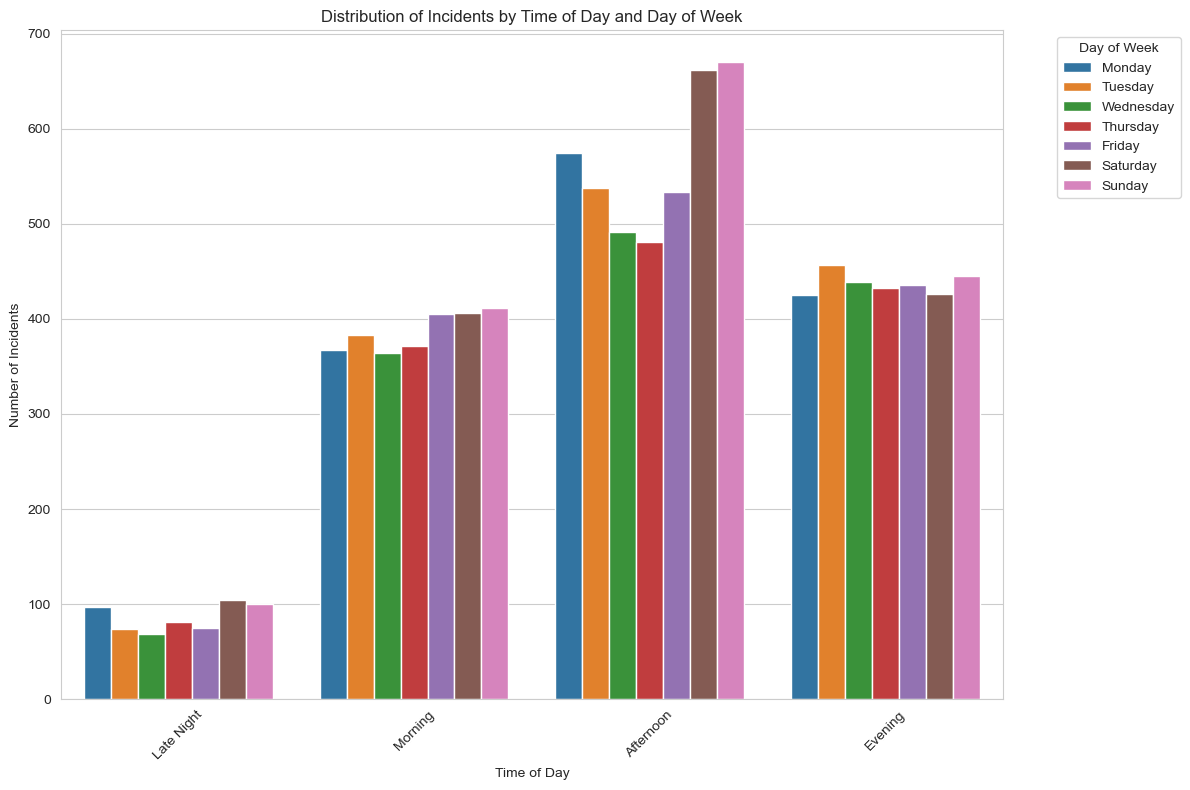

In [92]:
#Using Seaborn
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))
sns.countplot(x='PartOfDay', hue='DayOfWeekName', data=eda_lfb,
              order=['Late Night', 'Morning', 'Afternoon', 'Evening'],
              hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


plt.title('Distribution of Incidents by Time of Day and Day of Week')
plt.xlabel('Time of Day')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [93]:
eda_lfb['Incident'] = 1
avg_incidents_yearly_partofday = eda_lfb.groupby(['Year', 'PartOfDay'])['Incident'].count().reset_index()
avg_incidents_yearly_partofday

,Year,PartOfDay,Incident
0,2009,Afternoon,230
1,2009,Evening,150
2,2009,Late Night,20
3,2009,Morning,168
4,2010,Afternoon,254
5,2010,Evening,156
6,2010,Late Night,32
7,2010,Morning,169
8,2011,Afternoon,239
9,2011,Evening,168


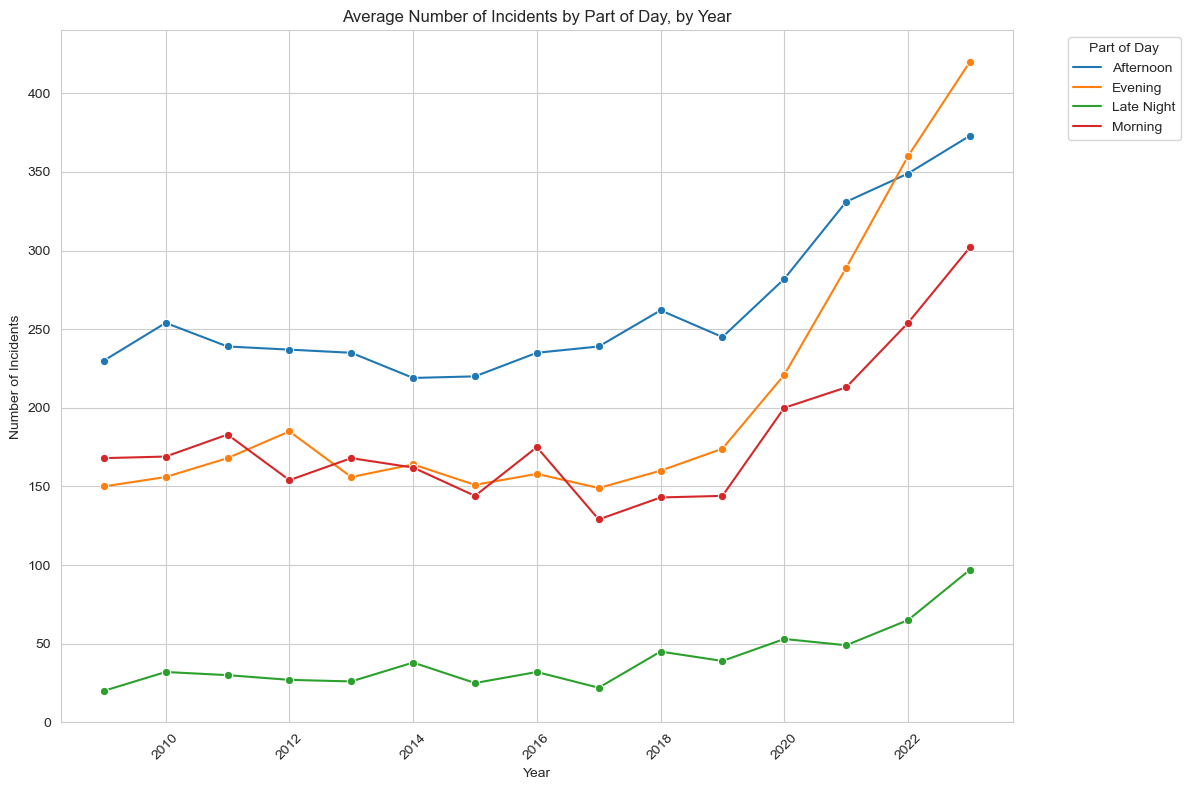

In [94]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=avg_incidents_yearly_partofday, x='Year', y='Incident', hue='PartOfDay', marker='o', palette='tab10')

plt.title('Average Number of Incidents by Part of Day, by Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend(title='Part of Day', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [95]:
#Using plotly express
fig = px.line(avg_incidents_yearly_partofday, x='Year', y='Incident', color='PartOfDay',
              title='Average Number of Incidents by Part of Day, by Year',
              labels={'Incident':'Number of Incidents', 'Year':'Year', 'PartOfDay':'Part of Day'},
              markers=True)

# Customize the layout
fig.update_layout(xaxis_title='Year',
                  yaxis_title='Average Number of Incidents',
                  legend_title='Part of Day',
                  xaxis=dict(tickmode='linear'),
                  template='plotly_white')

# Show the plot
fig.show()